Loading Data In

In [889]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Read the CSV files into dfs
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

# Merge the dfs on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

# Print the merged df
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(9813, 1389)


In [890]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSDIET', 'DRQSPREP', 'MCQ010', 'MCQ160F', 'CDQ001', 'OCQ210', 'DIQ010', 'DIQ160',
    'PAQ650', 'PAQ665', 'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020','ALQ101','ALQ151', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SLD010H', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD641', 'SMD650', 'SMD030'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,DBQ700,HSD010,SLD010H,SMQ050Q,SMQ050U,SMD055,SMD057,SMD641,SMD650,SMD030
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,2.0,2.0,7.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,3.0,4.0,9.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,8.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,2.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,5.0,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0


In [891]:
print(df.loc[df['ALQ120Q'] > 0])

       SEQN  RIAGENDR  RIDAGEYR  DMDEDUC2  BPXDI1  BPXDI2  BPXDI3  BPXSY1  \
0     73557         1        69       3.0    72.0    76.0    74.0   122.0   
1     73558         1        54       3.0    62.0    80.0    42.0   156.0   
5     73562         1        56       4.0    84.0    82.0    80.0   160.0   
7     73564         2        61       5.0    80.0    80.0    82.0   118.0   
8     73566         2        56       3.0    74.0    72.0    72.0   128.0   
...     ...       ...       ...       ...     ...     ...     ...     ...   
9793  83712         1        61       2.0    70.0    78.0    74.0   124.0   
9801  83720         1        36       4.0    88.0    90.0     NaN   130.0   
9802  83721         1        52       5.0    70.0    72.0    76.0   108.0   
9804  83723         1        61       2.0     NaN    60.0    68.0     NaN   
9808  83727         1        26       5.0    68.0    74.0    76.0   110.0   

      BPXSY2  BPXSY3  ...  DBQ700  HSD010  SLD010H  SMQ050Q  SMQ050U  SMD05

In [892]:
df.isnull().sum()

SEQN           0
RIAGENDR       0
RIDAGEYR       0
DMDEDUC2     336
BPXDI1       498
BPXDI2       305
BPXDI3       300
BPXSY1       498
BPXSY2       305
BPXSY3       300
BMXBMI        77
BMXHT         67
BMXWAIST     337
BMXWT         64
BPQ080         0
DRQSDIET     528
DRQSPREP     528
MCQ010         0
MCQ160F      336
CDQ001      2216
OCQ210      4996
DIQ010         0
DIQ160       882
PAQ650         0
PAQ665         0
DPQ050       529
DPQ040       529
DPQ030       529
DPQ020       528
ALQ101       503
ALQ151      1447
ALQ120Q     1445
ALQ120U     2331
ALQ130      2328
SMQ020         0
SMQ040      3434
DBQ700         0
HSD010       480
SLD010H        3
SMQ050Q     4617
SMQ050U     4670
SMD055      4745
SMD057      4617
SMD641      4741
SMD650      4754
SMD030      3434
dtype: int64

In [893]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)
df.loc[df['ALQ120Q'] == 0, ['ALQ130']] = df.loc[df['ALQ120Q'] == 0, ['ALQ130']].fillna(0)

df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)

df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

In [894]:
df.isnull().sum()

SEQN           0
RIAGENDR       0
RIDAGEYR       0
DMDEDUC2     336
BPXDI1       498
BPXDI2       305
BPXDI3       300
BPXSY1       498
BPXSY2       305
BPXSY3       300
BMXBMI        77
BMXHT         67
BMXWAIST     337
BMXWT         64
BPQ080         0
DRQSDIET     528
DRQSPREP     528
MCQ010         0
MCQ160F      336
CDQ001      2216
OCQ210      4996
DIQ010         0
DIQ160       882
PAQ650         0
PAQ665         0
DPQ050       529
DPQ040       529
DPQ030       529
DPQ020       528
ALQ101       503
ALQ151       507
ALQ120Q      505
ALQ120U     1054
ALQ130       505
SMQ020         0
SMQ040         0
DBQ700         0
HSD010       480
SLD010H        3
SMQ050Q     4617
SMQ050U     4670
SMD055      4745
SMD057      4617
SMD641      4741
SMD650      4754
SMD030      3434
dtype: int64

In [895]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSDIET': 'Diet',
    'DRQSPREP': 'SaltFreq',
    'MCQ010': 'Asthma',
    'MCQ160F': 'Stroke',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'DPQ050': 'FeelPoorEating',
    'DPQ040': 'FeelTired',
    'DPQ030': 'SleepTroubles',
    'DPQ020': 'FeelDepressed',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ120U' : 'UnitAlc',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SLD010H': 'SleepDuringWork',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'DIQ160' : 'Prediabetic',
    'SMD030' : 'AgeStartedSmokingReg',
    'SMQ050Q': 'TimeQuit',
    'SMD055': 'AgeLastSmokedReg',
    'SMD057': 'WhenSmokedCigs/Day',
    'SMD641': 'DaysSmokedInLast30',
    'SMD650': 'AvgCigs/DayInLast30'
}

df.rename(columns=new_column_names, inplace=True)

# Show the first few rows to verify the changes
df.head()

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,OvrDietHealth,GenHealth,SleepDuringWork,TimeQuit,SMQ050U,AgeLastSmokedReg,WhenSmokedCigs/Day,DaysSmokedInLast30,AvgCigs/DayInLast30,AgeStartedSmokingReg
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,2.0,2.0,7.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,3.0,4.0,9.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,8.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,2.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,5.0,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0


## Feature Descriptions

### Cholesterol
- **Question:** Do you suffer from high cholesterol?

### Diet
- **Question:** Are you on a diet?

### Salt Frequency
- **Question:** How often do you add salt to your food?
  - 1 = Never
  - 2 = Rarely
  - 3 = Occasionally
  - 4 = Very Often

### Asthma
- **Question:** Have you ever been told you have asthma? (Refer to MCQ035 to check if you still have it)

### Stroke
- **Question:** Have you ever had a stroke?

### Vigorous Activity
- **Question:** Do you engage in any vigorous activity?

### Moderate Activity
- **Question:** Do you engage in any moderate activity?

### Over the Last 2 Weeks...
- **FeelPoorEating:** Have you been bothered by poor eating or appetite?
- **FeelTired:** Have you felt tired?
- **SleepTroubles:** Have you struggled to fall asleep, stay asleep, or slept too much?
- **FeelDepressed:** Have you felt depressed?

### Alcohol Consumption
- **AlcConsumpMoreThan4/5MostDays:** Have you ever consumed more than 4/5 drinks on most days?
- **AlcConsumpFreq:** How many days have you consumed alcohol in the past year?
- **AlcConsumpAmtPerDrinkDay:** On days you drank in the last year, on average, how many drinks did you have?

### Smoking
- **SMD030:** Age started smoking regularly (skip if < 100 cigs)
  - 7-64
  - 0 = Never regular
  - 80 = 80+
- **Smoker:** Do you currently smoke?
  - 1 = Every day
  - 2 = Some days
  - 3 = Never
- **SMQ050Q:** How long since you quit? (Skip if smoker = 1/2)
- **SMD055:** Age last smoked regularly (skip if still smokes/< 100 cigs)
- **SMD057:** When did you smoke, how many? (Skip if still smokes/< 100 cigs)
  - 1-90
  - 95+
- **SMD641:** Days smoked in the past 30 days (skip if not a current smoker)
- **SMD650:** Average number of cigarettes per day in the past 30 days (skip if not a current smoker)

### Overall Diet Health
- **Question:** How would you rate the health of your diet?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### General Health
- **Question:** How would you rate your general health condition?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### Sleep During Work Days
- **Question:** How much sleep do you get during work days?
  - 2-11 hours
  - 12 = 12+ hours

### Education Level
- **Question:** What is the highest level of school that you have completed?
  - 1 = Less than grade 9
  - 2 = Less than matriculated
  - 3 = High school graduate
  - 4 = Some college degree
  - 5 = College graduate or higher

### Diabetes
- **Question:** Has a doctor ever told you that you have diabetes?
  - 1 = Yes
  - 2 = No
  - 3 = Borderline

### Prediabetic
- **Question:** Has a doctor ever told you that you are prediabetic?


In [896]:
df.head()

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,OvrDietHealth,GenHealth,SleepDuringWork,TimeQuit,SMQ050U,AgeLastSmokedReg,WhenSmokedCigs/Day,DaysSmokedInLast30,AvgCigs/DayInLast30,AgeStartedSmokingReg
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,2.0,2.0,7.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,3.0,4.0,9.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,8.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,2.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,5.0,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0


## Data Exploration

### Preliminary Feature Engineering

In [897]:
def plot_bivariate(col, hue):
    if df[col].nunique() > 5:
        plt.figure(figsize=(20, 10))
        rot = 90
    else:
        plt.figure(figsize=(10, 7))
        rot = 0

    def percentage(ax):
        heights = [[p.get_height() for p in bars] for bars in ax.containers]  # Get the counts of each bar, make arrays when more than one in group
        min_length = min(len(group) for group in heights)  # Find the minimum length of the groups
        for bars in ax.containers:
            for i, p in enumerate(bars):
                if i >= min_length:
                    continue  # Skip if index is out of range for any group
                total = sum(group[i] for group in heights)  # Sum total of each group
                percentage = (100 * p.get_height() / total)  # Calculate % to annotate
                ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() * 0.5, 0.8 * p.get_height()), 
                            ha='center', va='bottom', rotation=0)
                if percentage > 25.0:
                    percentage = f'{percentage:.1f}%'
                    ax.annotate(percentage, (p.get_x() + p.get_width() * 0.5, 0.25 * p.get_height()), 
                                ha='center', va='center', rotation=rot)

    plot = sns.countplot(x=df[col], hue=df[hue], palette='pastel')
    percentage(plot)
    plt.xticks(rotation=rot)
    plt.show()

In [898]:
def calculate_average(df, features, new_feature_name):
    # Check and select the relevant columns from the df
    relevant_columns = df[features].replace({0: np.nan})  # Replace zeros with NaN to exclude from mean calculation
    
    # Calculate the mean across the specified columns, ignoring NaN values
    df[new_feature_name] = relevant_columns.mean(axis=1, skipna=True)

In [899]:
diasBP_features = ['DiasBP1', 'DiasBP2', 'DiasBP3']
sysBP_features = ['SysBP1', 'SysBP2', 'SysBP3']

calculate_average(df, diasBP_features, 'AvgDiasBP')
calculate_average(df, sysBP_features, 'AvgSysBP')

In [900]:
# Drop rows where AvgSysBP is null
df = df.dropna(subset=['AvgSysBP'])

In [901]:

conditions = [
    df['AvgSysBP'] < 130,
    (df['AvgSysBP'] >= 130) & (df['AvgSysBP'] < 140),
    df['AvgSysBP'] >= 140
]
values = ['Normal', 'Elevated', 'High']

# Use np.select to handle NaNs and assign the appropriate category
df['HypertensionLvl'] = np.select(conditions, values, default=np.nan)

In [902]:
df.head(20)

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,TimeQuit,SMQ050U,AgeLastSmokedReg,WhenSmokedCigs/Day,DaysSmokedInLast30,AvgCigs/DayInLast30,AgeStartedSmokingReg,AvgDiasBP,AvgSysBP,HypertensionLvl
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,4.0,66.0,2.0,NaN,NaN,17.0,74.000000,112.666667,Normal
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,NaN,NaN,NaN,NaN,1.0,1.0,0.0,61.333333,157.333333,High
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,40.0,4.0,26.0,3.0,NaN,NaN,20.0,82.000000,142.000000,High
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.666667,137.333333,Elevated
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,16.0,4.0,40.0,5.0,NaN,NaN,18.0,82.000000,157.333333,High
7,73564,2,61,5.0,80.0,80.0,82.0,118.0,124.0,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.666667,122.666667,Normal
8,73566,2,56,3.0,74.0,72.0,72.0,128.0,124.0,114.0,...,NaN,NaN,NaN,NaN,30.0,1.0,33.0,72.666667,122.000000,Normal
9,73567,1,65,2.0,78.0,78.0,76.0,140.0,142.0,142.0,...,NaN,NaN,NaN,NaN,30.0,25.0,21.0,77.333333,141.333333,High
10,73568,2,26,5.0,60.0,62.0,66.0,106.0,100.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.666667,104.666667,Normal
12,73571,1,76,5.0,68.0,NaN,68.0,124.0,NaN,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.000000,126.000000,Normal


In [903]:
# Print the 'Age' values where '100cigs' is NaN
print(df.loc[df['100Cigs'].isna(), 'Age'])

Series([], Name: Age, dtype: int64)


Based on the data description and skips prescribed in the questionaire, should a person not have smoked more than 100 cigarettes in their lifetime, the following features are imputed with nans:
- AgeStartedSmokingReg
- Smoker
- TimeQuit
- AgeLastSmokedReg
- HowMany/DayWhenSmoked
- DaysSmokedInLast30
- Cigs/DayInLast30

We also know that no null values are present due to actual missing information, since all the null values in the 100Cigs feature, were due to children, as demonstrated by the 0 null values in the feature shown above, after children records are removed. The only other null values present in these features would be due to not being smokers, or being smokers

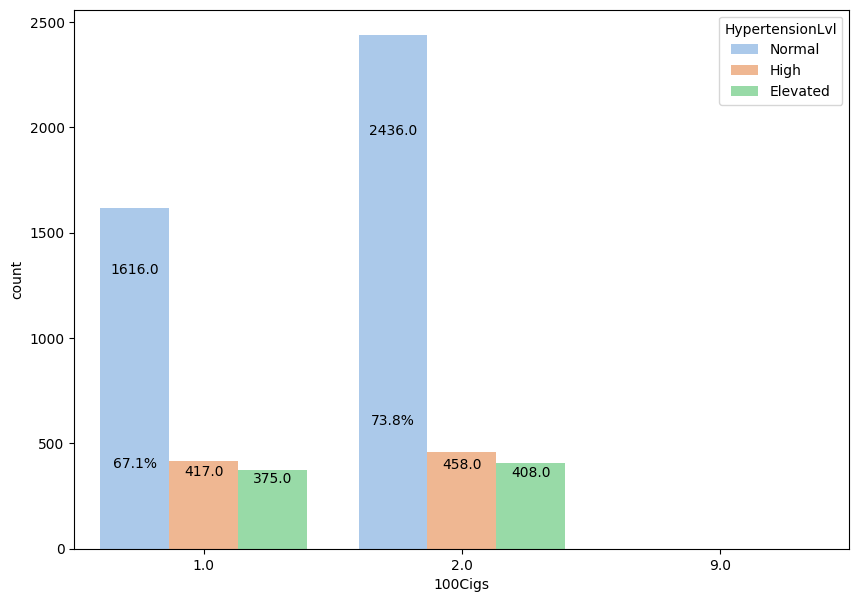

In [904]:
plot_bivariate('100Cigs', 'HypertensionLvl')

### Years Smoked

In [905]:
df.loc[df['TimeQuit'] == 66666, 'TimeQuit'] = 50

In [906]:
# Define the transformation function
def transform_time_quit(row):
    if row['SMQ050U'] == 1:
        return 0
    elif row['SMQ050U'] == 2:
        return (row['TimeQuit'] / 52)
    elif row['SMQ050U'] == 3:
        return (row['TimeQuit'] / 12)
    else:
        return row['TimeQuit']

# Apply the transformation to the TimeQuit column
df['TimeQuit'] = df.apply(transform_time_quit, axis=1)


In [907]:
# Filter the DataFrame based on the conditions
filtered_df = df[
    (df['AgeLastSmokedReg'].isnull() & df['TimeQuit'].notnull()) |
    (df['AgeLastSmokedReg'].notnull() & df['TimeQuit'].isnull())
]

# Print the filtered DataFrame
filtered_df[['AgeLastSmokedReg', 'TimeQuit', 'Smoker', 'Age', 'AgeStartedSmokingReg']].tail(30)

,AgeLastSmokedReg,TimeQuit,Smoker,Age,AgeStartedSmokingReg
7317,NaN,0.666667,3.0,46,16.0
7370,NaN,0.500000,3.0,38,16.0
7457,NaN,0.583333,3.0,21,13.0
7655,NaN,0.019231,3.0,38,16.0
7695,NaN,0.115385,3.0,46,0.0
7719,NaN,0.500000,3.0,31,16.0
7798,NaN,0.057692,3.0,70,18.0
7800,NaN,0.057692,3.0,39,18.0
7855,NaN,0.166667,3.0,31,30.0
7970,NaN,99999.000000,3.0,75,15.0


In [908]:
# Update AgeLastSmokedReg where it is null, TimeQuit is not null, and TimeQuit is smaller than 100
df.loc[(df['AgeLastSmokedReg'].isnull()) & (df['TimeQuit'].notnull()) & (df['TimeQuit'] < 100) & (df['Smoker'] == 3) & (df['100Cigs'] == 1), 'AgeLastSmokedReg'] = df['Age'] - df['TimeQuit']

# Verify the changes
print(df.loc[(df['TimeQuit'].notna()), ['Age', 'TimeQuit', 'AgeLastSmokedReg', 'AgeStartedSmokingReg']].head(20))

     Age   TimeQuit  AgeLastSmokedReg  AgeStartedSmokingReg
0     69   3.000000         66.000000                  17.0
2     72  40.000000         26.000000                  20.0
5     56  16.000000         40.000000                  18.0
18    32   0.666667         31.333333                  10.0
36    58  15.000000         25.000000                  19.0
37    57  20.000000         37.000000                   0.0
48    75  17.000000         58.000000                  16.0
57    62  22.000000         40.000000                  16.0
60    36   1.500000         34.000000                  23.0
62    80  45.000000         30.000000                  17.0
68    80  12.000000         70.000000                  16.0
78    71  20.000000         51.000000                  30.0
82    62   5.000000         56.000000                  14.0
84    54   7.000000         47.000000                  15.0
98    59   1.000000         58.000000                  30.0
104   70  25.000000         45.000000   

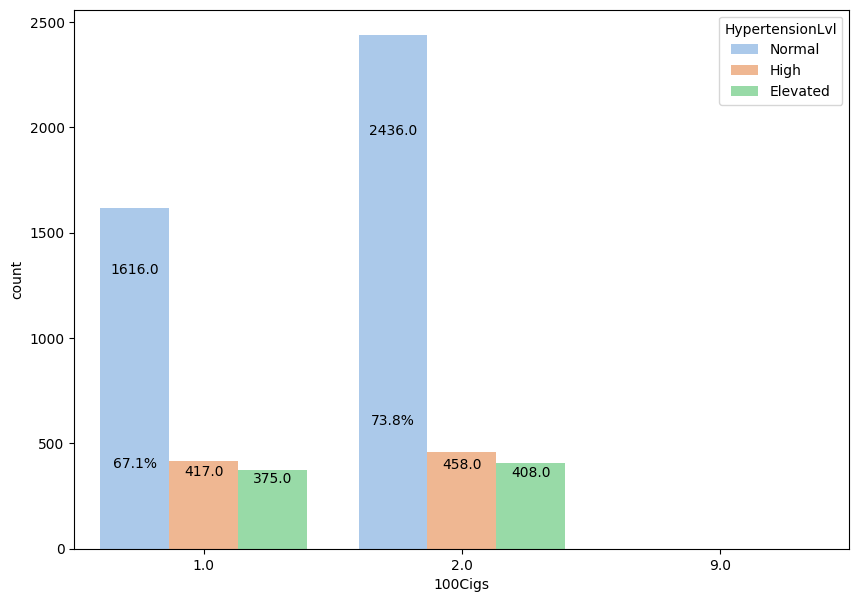

In [909]:
plot_bivariate('100Cigs', 'HypertensionLvl')

In [910]:
df.loc[df['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan
df.loc[df['TimeQuit'] > 66666, 'TimeQuit'] = np.nan
df.loc[df['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan
df = df.drop(columns=['SMQ050U'])

df['yearsSmoked'] = np.where(
    df['Smoker'].isin([1, 2]),
    df['Age'] - df['AgeStartedSmokingReg'],
    df['AgeLastSmokedReg'] - df['AgeStartedSmokingReg']
)

df['yearsSmoked'] = df['yearsSmoked'].fillna(0)

C:\Users\larry\AppData\Local\Temp\ipykernel_32452\3170566072.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


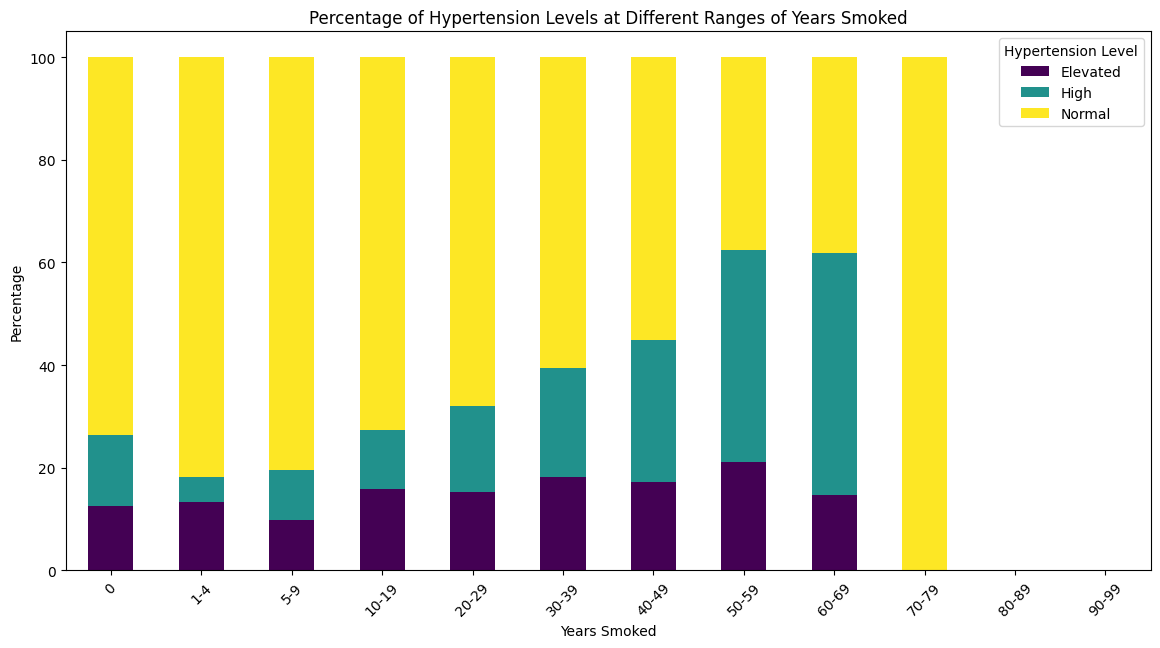

In [911]:
# Bin the yearsSmoked values
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['yearsSmokedBinned'] = pd.cut(df['yearsSmoked'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Years Smoked')
plt.xlabel('Years Smoked')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

In [912]:
# Filter the DataFrame for rows where Smoker is 1 or 2 and AvgCigs/Day is NaN
filtered_df = df[(df['Smoker'].isin([1, 2])) & (df['DaysSmokedInLast30'] == 0)]

# Print the filtered rows
print(filtered_df[['Smoker', 'DaysSmokedInLast30']].head(20))

      Smoker  DaysSmokedInLast30
2075     2.0                 0.0
2936     2.0                 0.0
3324     2.0                 0.0
4521     2.0                 0.0
5069     2.0                 0.0
5340     2.0                 0.0
5358     2.0                 0.0
5806     2.0                 0.0
6824     2.0                 0.0
6880     2.0                 0.0
7791     2.0                 0.0
9261     2.0                 0.0


In [913]:
# Filter the DataFrame for the specified conditions
filtered_df = df[df['WhenSmokedCigs/Day'].isnull()]

# Print the value counts of the filtered rows
print(filtered_df['HypertensionLvl'].value_counts())

HypertensionLvl
Normal      3247
High         630
Elevated     571
Name: count, dtype: int64


In [914]:
# Define the transformation function
def calculate_lifetime_cigarettes(row):
    if row['Smoker'] == 3:
        if pd.isnull(row['WhenSmokedCigs/Day']) | (row['WhenSmokedCigs/Day'] > 100):
            return 0
        return row['yearsSmoked'] * row['WhenSmokedCigs/Day'] * 365
    elif row['Smoker'] in [1, 2]:
        if pd.isnull(row['AvgCigs/DayInLast30']) | (row['AvgCigs/DayInLast30'] > 100):
            return 0
        return row['yearsSmoked'] * row['AvgCigs/DayInLast30'] * row['DaysSmokedInLast30'] /30 * 365
    else:
        return np.nan

# Apply the transformation to create the lifetimeCigarettes feature
df['lifetimeCigarettes'] = df.apply(calculate_lifetime_cigarettes, axis=1)

# Verify the changes
print(df[['Smoker', 'yearsSmoked', 'WhenSmokedCigs/Day', 'AvgCigs/DayInLast30', 'DaysSmokedInLast30', 'lifetimeCigarettes']].head(20))

    Smoker  yearsSmoked  WhenSmokedCigs/Day  AvgCigs/DayInLast30  \
0      3.0    49.000000                 2.0                  NaN   
1      2.0    54.000000                 NaN                  1.0   
2      3.0     6.000000                 3.0                  NaN   
4      3.0     0.000000                 NaN                  NaN   
5      3.0    22.000000                 5.0                  NaN   
7      3.0     0.000000                 NaN                  NaN   
8      1.0    23.000000                 NaN                  1.0   
9      1.0    44.000000                 NaN                 25.0   
10     3.0     0.000000                 NaN                  NaN   
12     3.0     0.000000                 NaN                  NaN   
15     3.0     0.000000                 NaN                  NaN   
18     3.0    21.333333                20.0                  NaN   
19     3.0     0.000000                 NaN                  NaN   
21     3.0     0.000000                 NaN     

In [915]:
# Filter the DataFrame for the specified conditions
filtered_df = df[(df['lifetimeCigarettes'] < 100) & (df['HypertensionLvl'].isin(['Elevated', 'High']))]

# Print the value counts of the filtered rows
print(filtered_df['HypertensionLvl'].value_counts())

HypertensionLvl
High        473
Elevated    422
Name: count, dtype: int64


C:\Users\larry\AppData\Local\Temp\ipykernel_32452\2307530192.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


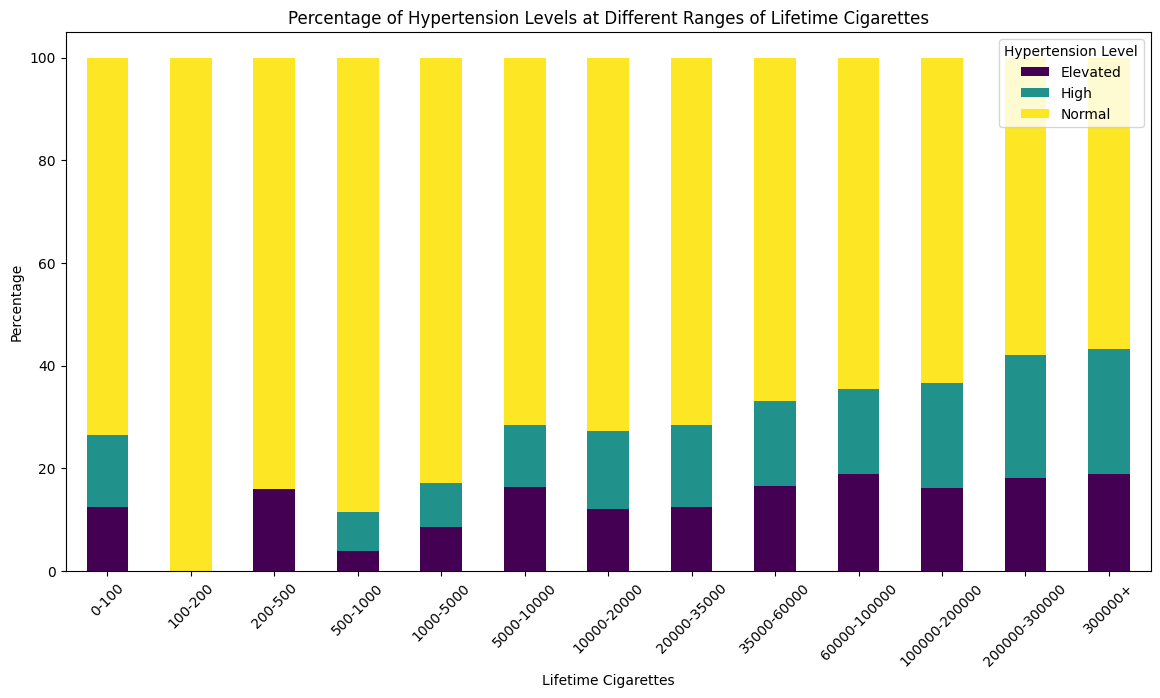

In [916]:
# Bin the lifetimeCigarettes values
bins = [0, 100, 200, 500, 1000, 5000, 10000, 20000, 35000, 60000, 100000, 200000, 300000, 1000000000000]
labels = ['0-100', '100-200', '200-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-35000', '35000-60000', '60000-100000', '100000-200000', '200000-300000', '300000+']
df['lifetimeCigarettesBinned'] = pd.cut(df['lifetimeCigarettes'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of lifetimeCigarettes
hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Lifetime Cigarettes')
plt.xlabel('Lifetime Cigarettes')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

### Alcohol

In [917]:
print(df.loc[df['AlcConsumpFreq'] > 7].value_counts)

<bound method DataFrame.value_counts of          ID  Gender  Age  EducationLvl  DiasBP1  DiasBP2  DiasBP3  SysBP1  \
18    73577       1   32           1.0     74.0     74.0     78.0   118.0   
84    73645       2   54           4.0     68.0     72.0     70.0   124.0   
161   73726       2   67           3.0     86.0     84.0      NaN   148.0   
261   73833       2   34           5.0     42.0     60.0     66.0    96.0   
377   73952       1   42           4.0     68.0     72.0     82.0   114.0   
...     ...     ...  ...           ...      ...      ...      ...     ...   
9603  83516       2   66           3.0     70.0     64.0     64.0   144.0   
9743  83662       1   80           4.0     76.0     66.0     56.0   194.0   
9755  83674       1   40           5.0     76.0     80.0     76.0   126.0   
9765  83684       1   80           5.0     78.0     72.0     74.0   134.0   
9783  83702       2   80           4.0     86.0     84.0     94.0   154.0   

      SysBP2  SysBP3  ...  DaysSmok

In [918]:
def transform_alc_consump_freq(row):
    if row['UnitAlc'] == 1:
        return (row['AlcConsumpFreq'] * 52)
    elif row['UnitAlc'] == 2:
        return (row['AlcConsumpFreq'] * 12)
    else:
        if (row['AlcConsumpFreq'] > 365):
            return np.nan
        return row['AlcConsumpFreq']
    

df['AlcConsumpFreq'] = df.apply(transform_alc_consump_freq, axis=1)

In [919]:
print(df.loc[df['AlcConsumpFreq'] > 7].value_counts)

<bound method DataFrame.value_counts of          ID  Gender  Age  EducationLvl  DiasBP1  DiasBP2  DiasBP3  SysBP1  \
1     73558       1   54           3.0     62.0     80.0     42.0   156.0   
8     73566       2   56           3.0     74.0     72.0     72.0   128.0   
9     73567       1   65           2.0     78.0     78.0     76.0   140.0   
10    73568       2   26           5.0     60.0     62.0     66.0   106.0   
18    73577       1   32           1.0     74.0     74.0     78.0   118.0   
...     ...     ...  ...           ...      ...      ...      ...     ...   
9784  83703       1   22           2.0     64.0     66.0     64.0   128.0   
9788  83707       1   18           NaN     54.0     50.0     54.0   106.0   
9790  83709       1   24           2.0     62.0     64.0     66.0   116.0   
9802  83721       1   52           5.0     70.0     72.0     76.0   108.0   
9808  83727       1   26           5.0     68.0     74.0     76.0   110.0   

      SysBP2  SysBP3  ...  DaysSmok

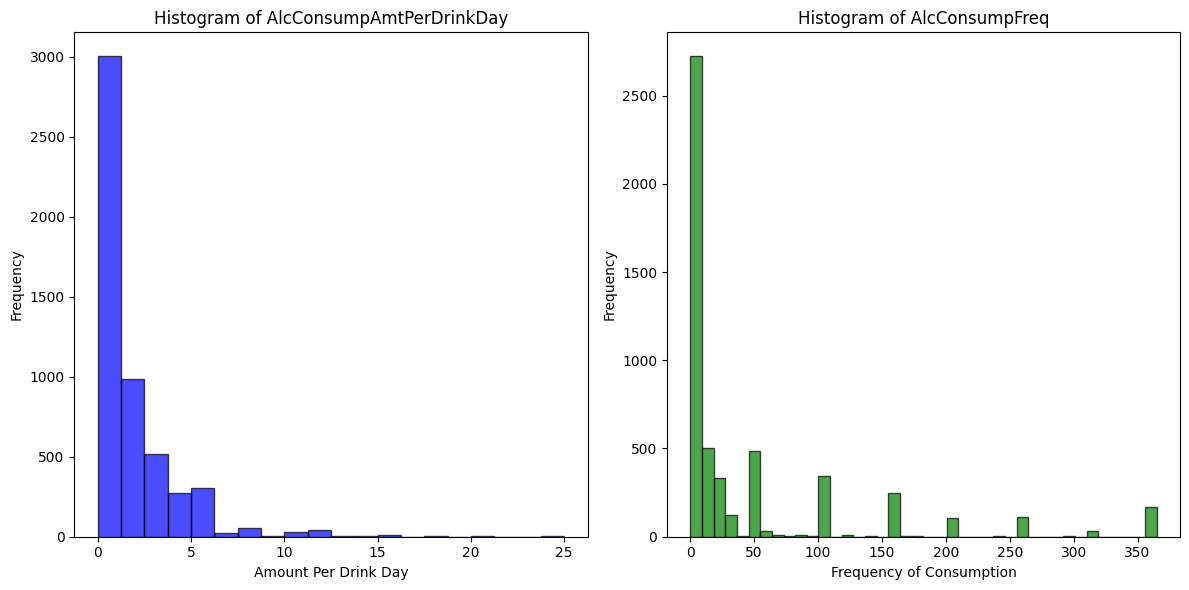

In [920]:
filtered_df = df[df['AlcConsumpAmtPerDrinkDay'] < 77]

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Histogram for AlcConsumpAmtPerDrinkDay
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(filtered_df['AlcConsumpAmtPerDrinkDay'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of AlcConsumpAmtPerDrinkDay')
plt.xlabel('Amount Per Drink Day')
plt.ylabel('Frequency')

# Histogram for AlcConsumpFreq
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(filtered_df['AlcConsumpFreq'], bins=40, color='green', edgecolor='black', alpha=0.7)
plt.title('Histogram of AlcConsumpFreq')
plt.xlabel('Frequency of Consumption')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [921]:
# Set values in 'AlcConsumpAmtPerDrinkDay' to NaN where the condition is met
df.loc[df['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan

# Calculate the new column 'AlcConsump/Yr' by multiplying the relevant columns
df['AlcConsump/Yr'] = df['AlcConsumpAmtPerDrinkDay'] * df['AlcConsumpFreq']

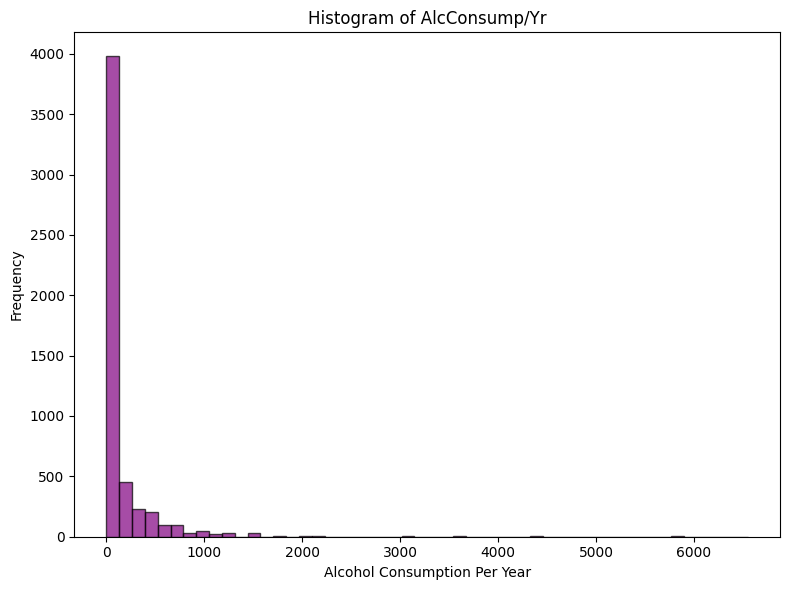

In [922]:
plt.figure(figsize=(8, 6))

# Histogram for AlcConsump/Yr
plt.hist(df['AlcConsump/Yr'], bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.title('Histogram of AlcConsump/Yr')
plt.xlabel('Alcohol Consumption Per Year')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\larry\AppData\Local\Temp\ipykernel_32452\981419561.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('AlcConsumpFreqBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


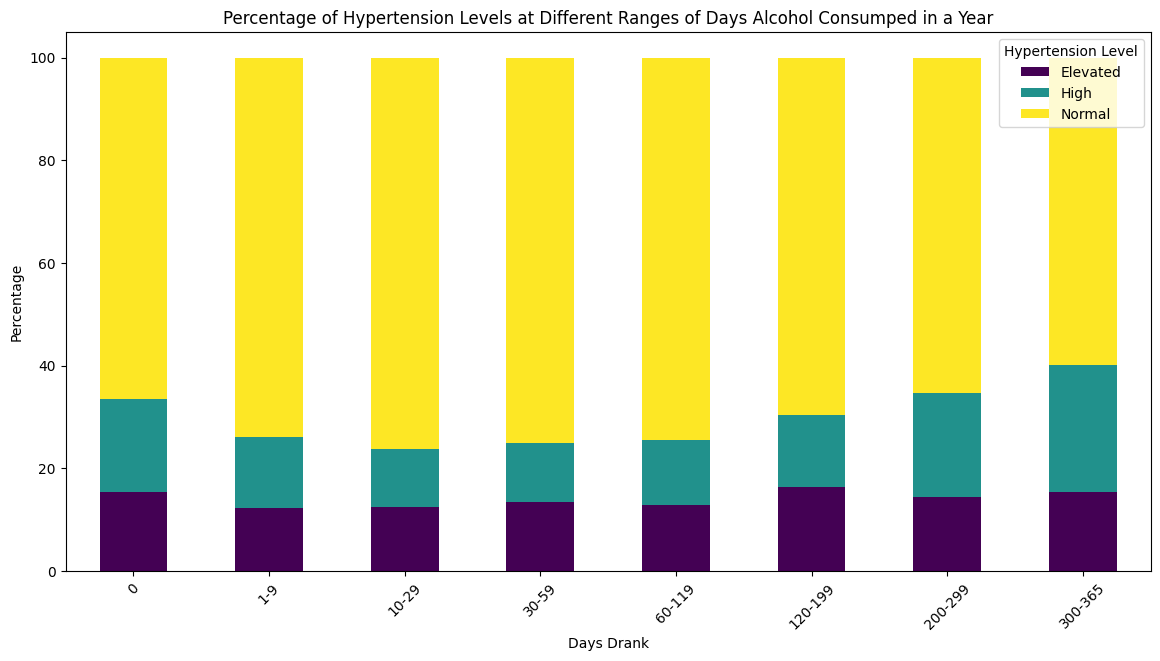

In [923]:
# Bin the yearsSmoked values
bins = [0, 1, 10, 30, 60, 120, 200, 299, 366]
labels = ['0', '1-9', '10-29', '30-59', '60-119', '120-199', '200-299', '300-365']
df['AlcConsumpFreqBinned'] = pd.cut(df['AlcConsumpFreq'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('AlcConsumpFreqBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Days Alcohol Consumped in a Year')
plt.xlabel('Days Drank')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

C:\Users\larry\AppData\Local\Temp\ipykernel_32452\2105518333.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('AlcConsump/YrBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


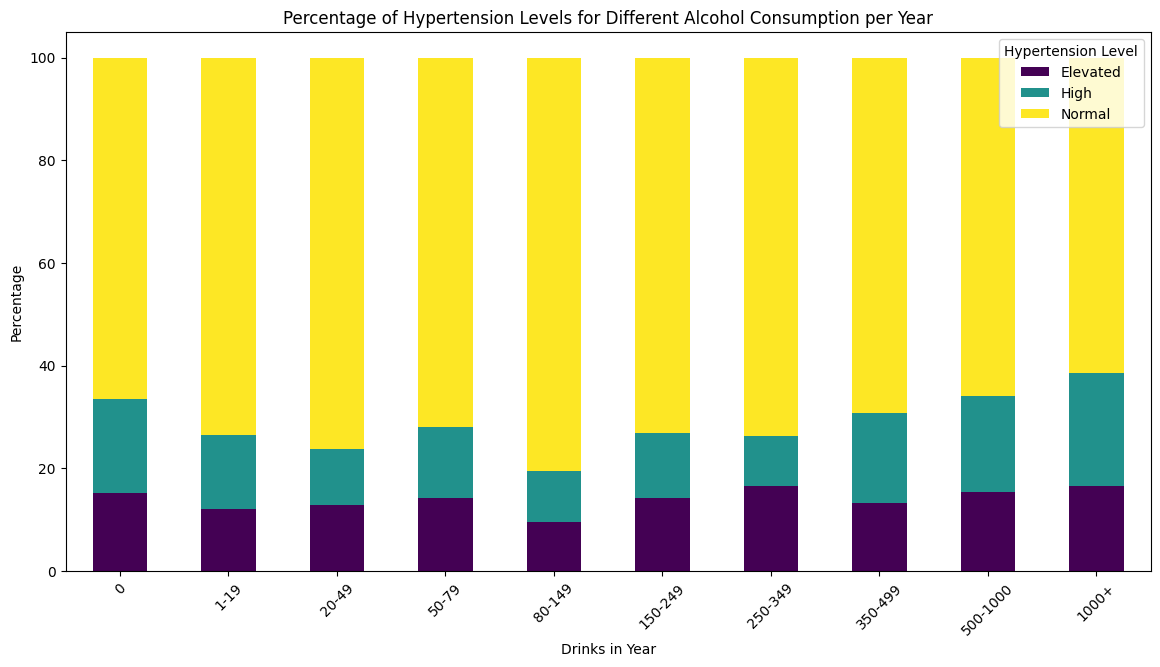

In [924]:
# Bin the yearsSmoked values
bins = [0, 1, 20, 50, 80, 150, 250, 350, 500, 1000, 1000000000]
labels = ['0', '1-19', '20-49', '50-79', '80-149', '150-249', '250-349', '350-499', '500-1000', '1000+']
df['AlcConsump/YrBinned'] = pd.cut(df['AlcConsump/Yr'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('AlcConsump/YrBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels for Different Alcohol Consumption per Year')
plt.xlabel('Drinks in Year')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

In [925]:
def plot_univariate(col):
    if(df[col].nunique()>2):
        plt.figure(figsize=(10,7))
        h = 0.15
        rot=90
    else:
        plt.figure(figsize=(6,6))
        h = 0.5
        rot=0
    plot = sns.countplot(x = df[col], palette='pastel')
    
    for bars in plot.containers:
        for p in bars:
            plot.annotate(format(p.get_height()), (p.get_x() + p.get_width()*0.5, p.get_height()), 
                    ha = 'center', va = 'bottom')
            plot.annotate(f'{p.get_height()*100/df[col].shape[0] : .1f}%', (p.get_x() + p.get_width()*0.5, h*p.get_height()), 
                    ha = 'center', va = 'bottom', rotation=rot)  

C:\Users\larry\AppData\Local\Temp\ipykernel_32452\1611043242.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(x = df[col], palette='pastel')


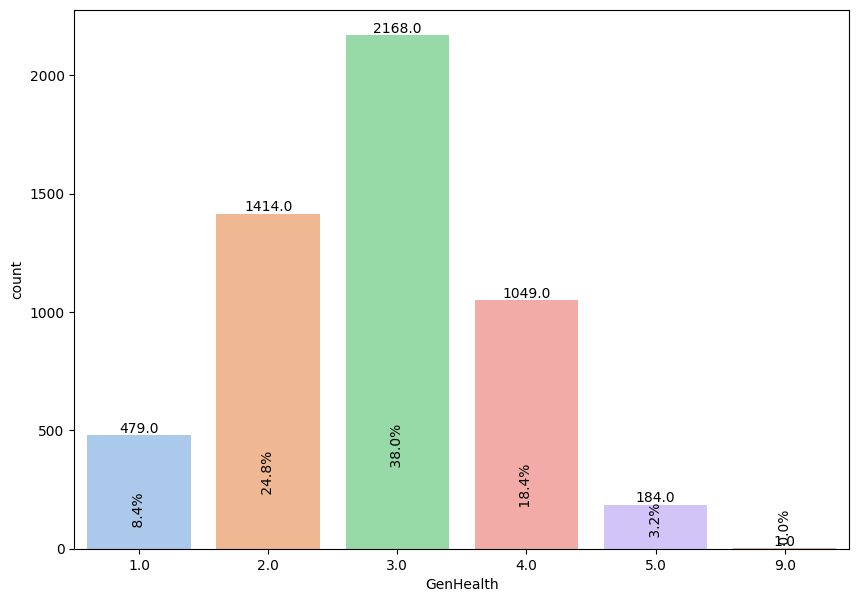

In [926]:
plot_univariate('GenHealth')

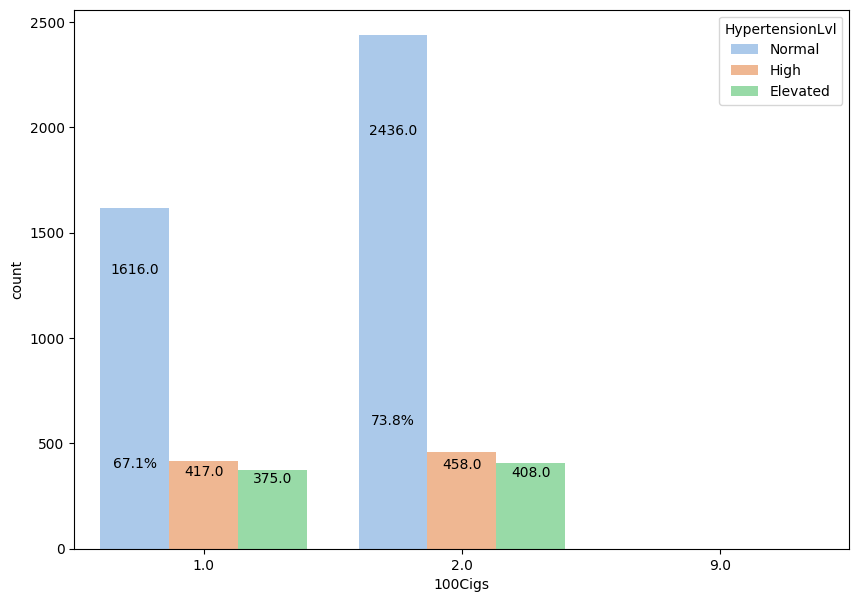

In [927]:
plot_bivariate('100Cigs', 'HypertensionLvl')

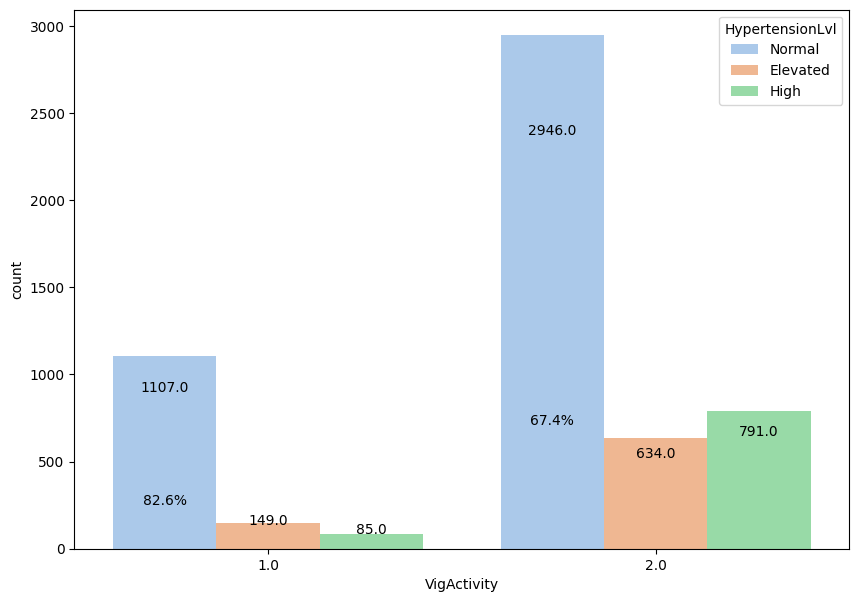

In [928]:
plot_bivariate('VigActivity', 'HypertensionLvl')

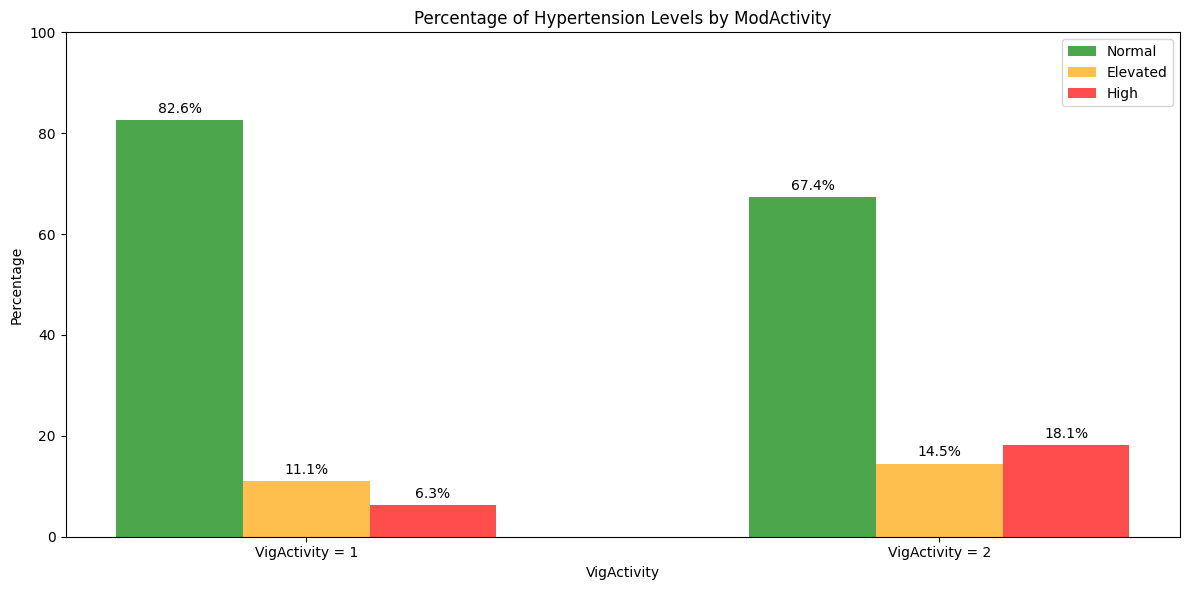

In [929]:
# Count records for each Hypertension Level when ModActivity = 1
high_hypertension_vig_1 = df[(df['HypertensionLvl'] == 'High') & (df['VigActivity'] == 1)].shape[0]
elevated_hypertension_vig_1 = df[(df['HypertensionLvl'] == 'Elevated') & (df['VigActivity'] == 1)].shape[0]
normal_hypertension_vig_1 = df[(df['HypertensionLvl'] == 'Normal') & (df['VigActivity'] == 1)].shape[0]

# Count records for each Hypertension Level when ModActivity = 2
high_hypertension_vig_2 = df[(df['HypertensionLvl'] == 'High') & (df['VigActivity'] == 2)].shape[0]
elevated_hypertension_vig_2 = df[(df['HypertensionLvl'] == 'Elevated') & (df['VigActivity'] == 2)].shape[0]
normal_hypertension_vig_2 = df[(df['HypertensionLvl'] == 'Normal') & (df['VigActivity'] == 2)].shape[0]

# Calculate total counts for each ModActivity
total_vig_1 = high_hypertension_vig_1 + elevated_hypertension_vig_1 + normal_hypertension_vig_1
total_vig_2 = high_hypertension_vig_2 + elevated_hypertension_vig_2 + normal_hypertension_vig_2

# Calculate percentages
percentages_vig_1 = [
    (normal_hypertension_vig_1 / total_vig_1) * 100,
    (elevated_hypertension_vig_1 / total_vig_1) * 100,
    (high_hypertension_vig_1 / total_vig_1) * 100
]

percentages_vig_2 = [
    (normal_hypertension_vig_2 / total_vig_2) * 100,
    (elevated_hypertension_vig_2 / total_vig_2) * 100,
    (high_hypertension_vig_2 / total_vig_2) * 100
]

# Data for plotting
labels = ['VigActivity = 1', 'VigActivity = 2']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the bars for each Hypertension Level next to each other
bar1 = plt.bar(x - width, [percentages_vig_1[0], percentages_vig_2[0]], width, label='Normal', color='green', alpha=0.7)
bar2 = plt.bar(x, [percentages_vig_1[1], percentages_vig_2[1]], width, label='Elevated', color='orange', alpha=0.7)
bar3 = plt.bar(x + width, [percentages_vig_1[2], percentages_vig_2[2]], width, label='High', color='red', alpha=0.7)

# Add percentages on top of the bars
for bar in [bar1, bar2, bar3]:
    for rect in bar:
        height = rect.get_height()
        plt.annotate(f'{height:.1f}%',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('VigActivity')
plt.ylabel('Percentage')
plt.title('Percentage of Hypertension Levels by ModActivity')
plt.xticks(x, labels)
plt.ylim(0, 100)  # Set y-axis limit to 100 for percentages
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


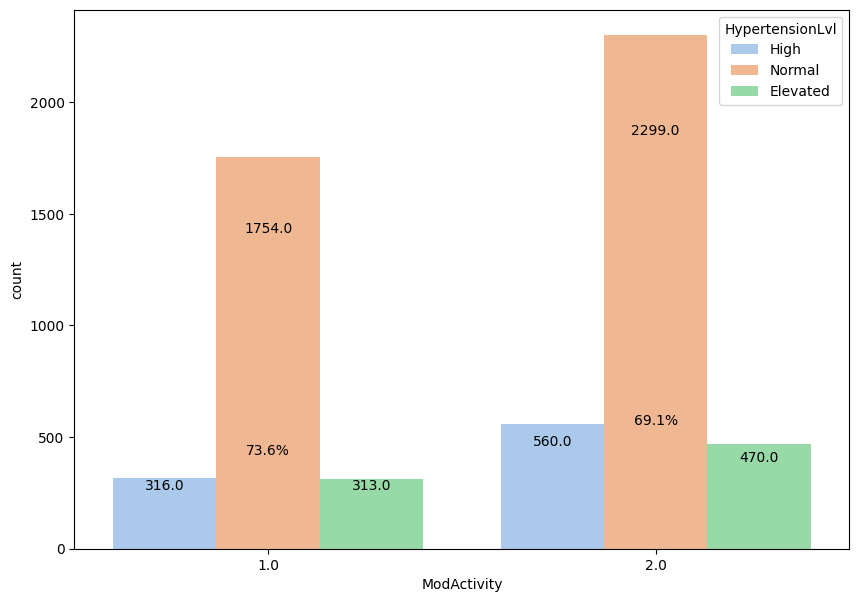

In [930]:
plot_bivariate('ModActivity', 'HypertensionLvl')

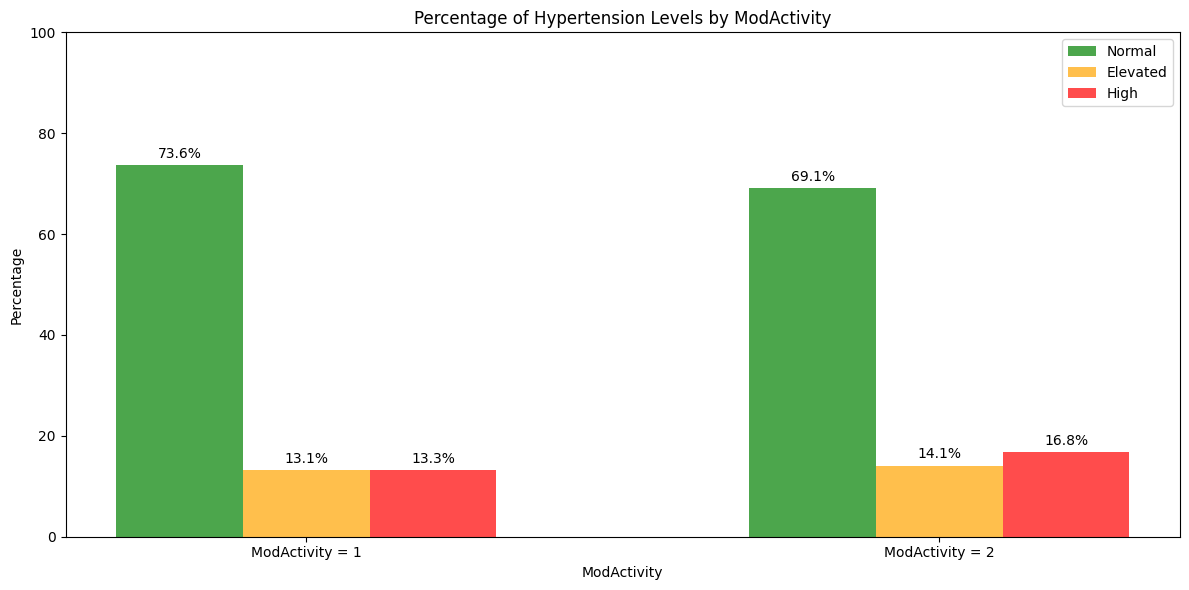

In [931]:
# Count records for each Hypertension Level when ModActivity = 1
high_hypertension_mod_1 = df[(df['HypertensionLvl'] == 'High') & (df['ModActivity'] == 1)].shape[0]
elevated_hypertension_mod_1 = df[(df['HypertensionLvl'] == 'Elevated') & (df['ModActivity'] == 1)].shape[0]
normal_hypertension_mod_1 = df[(df['HypertensionLvl'] == 'Normal') & (df['ModActivity'] == 1)].shape[0]

# Count records for each Hypertension Level when ModActivity = 2
high_hypertension_mod_2 = df[(df['HypertensionLvl'] == 'High') & (df['ModActivity'] == 2)].shape[0]
elevated_hypertension_mod_2 = df[(df['HypertensionLvl'] == 'Elevated') & (df['ModActivity'] == 2)].shape[0]
normal_hypertension_mod_2 = df[(df['HypertensionLvl'] == 'Normal') & (df['ModActivity'] == 2)].shape[0]

# Calculate total counts for each ModActivity
total_mod_1 = high_hypertension_mod_1 + elevated_hypertension_mod_1 + normal_hypertension_mod_1
total_mod_2 = high_hypertension_mod_2 + elevated_hypertension_mod_2 + normal_hypertension_mod_2

# Calculate percentages
percentages_mod_1 = [
    (normal_hypertension_mod_1 / total_mod_1) * 100,
    (elevated_hypertension_mod_1 / total_mod_1) * 100,
    (high_hypertension_mod_1 / total_mod_1) * 100
]

percentages_mod_2 = [
    (normal_hypertension_mod_2 / total_mod_2) * 100,
    (elevated_hypertension_mod_2 / total_mod_2) * 100,
    (high_hypertension_mod_2 / total_mod_2) * 100
]

# Data for plotting
labels = ['ModActivity = 1', 'ModActivity = 2']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the bars for each Hypertension Level next to each other
bar1 = plt.bar(x - width, [percentages_mod_1[0], percentages_mod_2[0]], width, label='Normal', color='green', alpha=0.7)
bar2 = plt.bar(x, [percentages_mod_1[1], percentages_mod_2[1]], width, label='Elevated', color='orange', alpha=0.7)
bar3 = plt.bar(x + width, [percentages_mod_1[2], percentages_mod_2[2]], width, label='High', color='red', alpha=0.7)

# Add percentages on top of the bars
for bar in [bar1, bar2, bar3]:
    for rect in bar:
        height = rect.get_height()
        plt.annotate(f'{height:.1f}%',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('ModActivity')
plt.ylabel('Percentage')
plt.title('Percentage of Hypertension Levels by ModActivity')
plt.xticks(x, labels)
plt.ylim(0, 100)  # Set y-axis limit to 100 for percentages
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [932]:
# Filter the DataFrame for records where ModActivity = 2 and VigActivity = 1
vig_activity_no_mod_activity = df[(df['ModActivity'] == 2) & (df['VigActivity'] == 1)]

# Print the filtered records with selected columns
print(vig_activity_no_mod_activity.loc[:, ['Age', 'ModActivity', 'VigActivity']])

      Age  ModActivity  VigActivity
22     50          2.0          1.0
39     20          2.0          1.0
64     32          2.0          1.0
68     80          2.0          1.0
73     43          2.0          1.0
...   ...          ...          ...
9709   58          2.0          1.0
9719   25          2.0          1.0
9780   37          2.0          1.0
9788   18          2.0          1.0
9801   36          2.0          1.0

[514 rows x 3 columns]


In [933]:
# Filter the DataFrame for records where ModActivity = 1 and VigActivity = 1
vig_activity_and_mod_activity = df[(df['ModActivity'] == 1) & (df['VigActivity'] == 1)]

# Print the filtered records with selected columns
print(vig_activity_and_mod_activity.loc[:, ['Age', 'ModActivity', 'VigActivity']])

      Age  ModActivity  VigActivity
12     76          1.0          1.0
19     18          1.0          1.0
26     28          1.0          1.0
57     62          1.0          1.0
93     44          1.0          1.0
...   ...          ...          ...
9759   42          1.0          1.0
9764   33          1.0          1.0
9769   29          1.0          1.0
9790   24          1.0          1.0
9802   52          1.0          1.0

[827 rows x 3 columns]


Clearly, people may perform only vigrous activity and not moderate activity, or both vigorous and moderate activity. Vigorous activity has a bigger impact on hypertension compared to moderate activity

In [934]:
#Combine vig and mod activity

df['ActivityLvl'] = df.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)

df['WeightedActivity'] = df.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

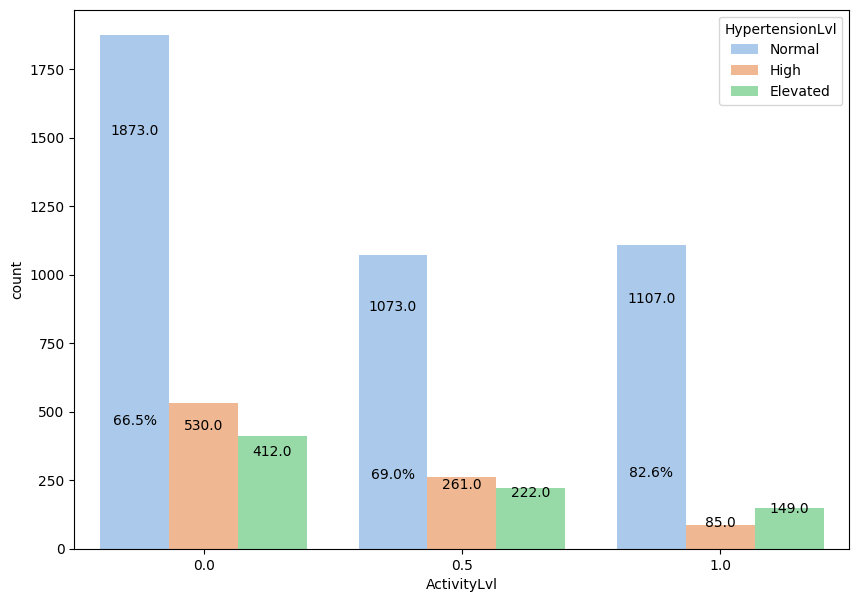

In [935]:
plot_bivariate('ActivityLvl', 'HypertensionLvl')

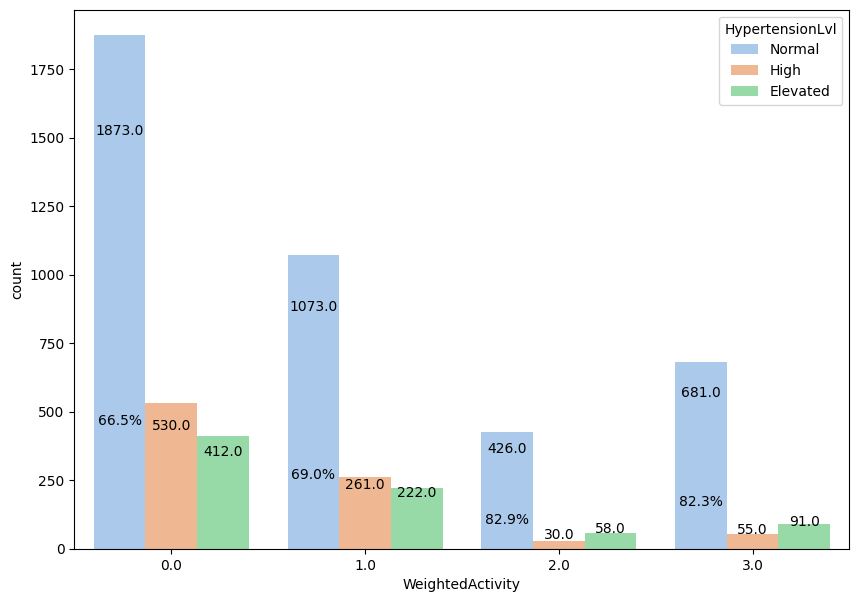

In [936]:
plot_bivariate('WeightedActivity', 'HypertensionLvl')

In [937]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_distribution(df, columns, threshold=7):
    # Loop through each specified column (feature) in the columns list
    for column in columns:
        # Check if the column exists in the df
        if column in df.columns:
            # Filter the data to include only values smaller than the threshold and skip null values
            filtered_data = df[column].dropna()
            filtered_data = filtered_data[filtered_data < threshold]
            
            # Check if the filtered data is not empty and contains valid numerical values
            if not filtered_data.empty and filtered_data.min() != filtered_data.max():
                # Plot the histogram for the filtered data with narrower bars
                plt.figure(figsize=(8, 5))
                plt.hist(filtered_data, bins=range(int(filtered_data.min()), int(filtered_data.max()) + 2), 
                         alpha=0.7, color='blue', edgecolor='black', width=0.5)  # Adjust 'width' for narrower bars
                
                # Set titles and labels
                plt.title(f'Frequency Distribution of {column}')
                plt.xlabel(column)
                plt.ylabel('Frequency')
                
                # Show the plot
                plt.show()
            else:
                print(f"No valid data to plot for column '{column}'.")
        else:
            print(f"Column '{column}' not found in the df.")


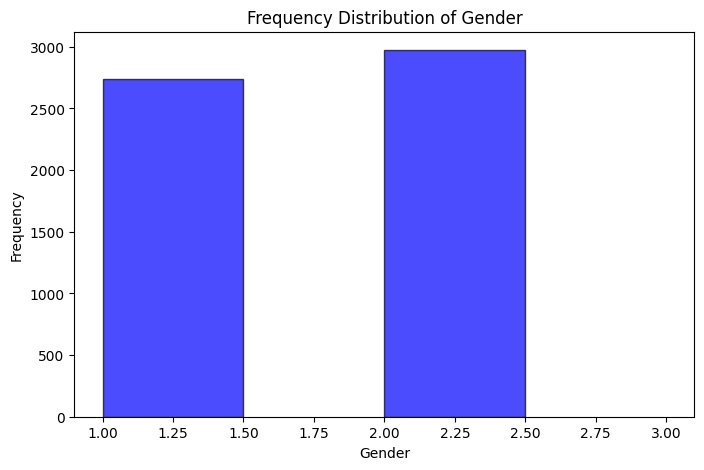

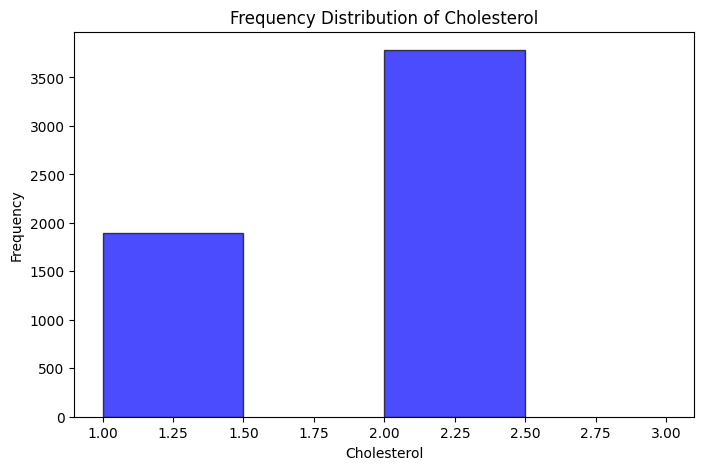

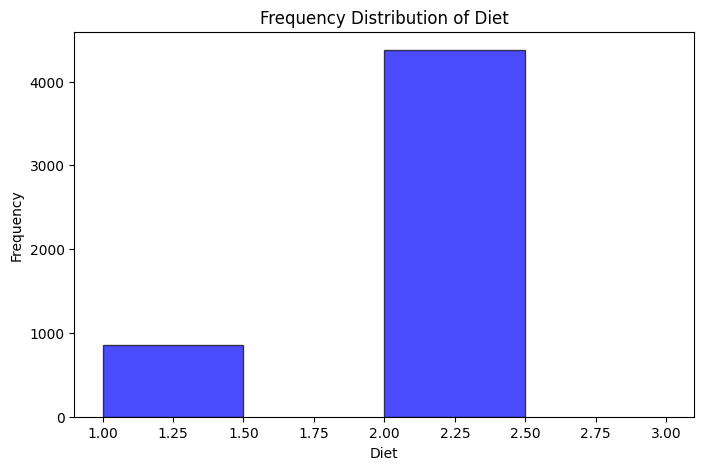

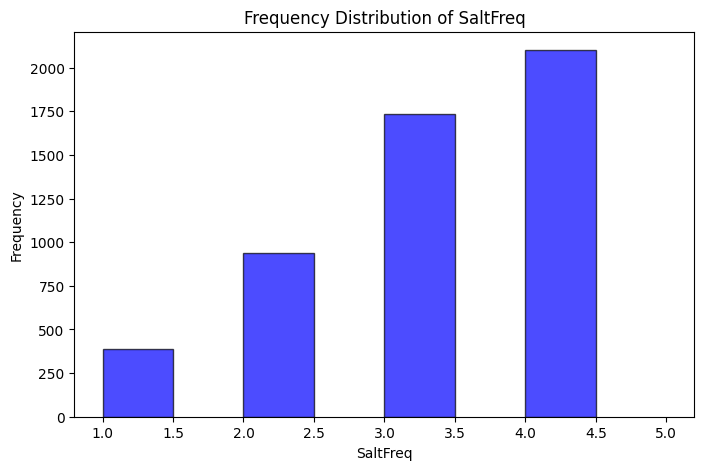

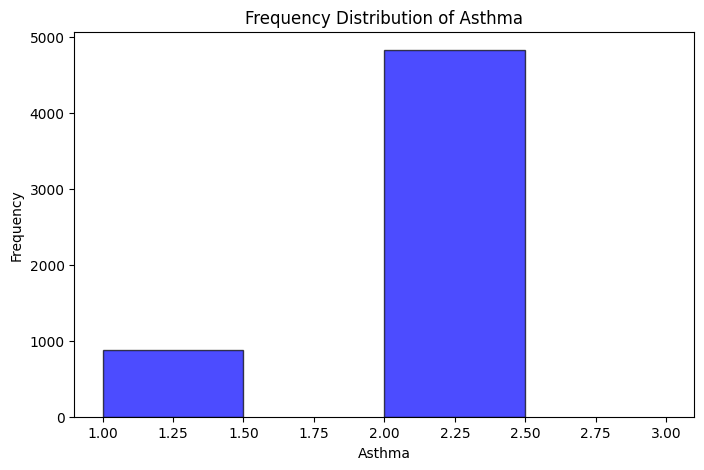

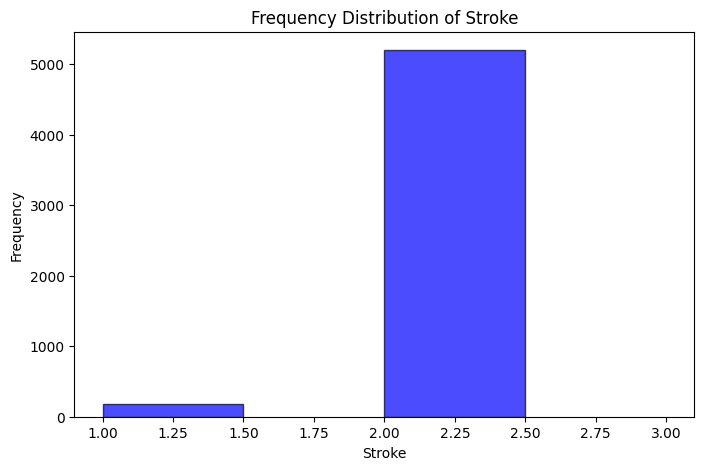

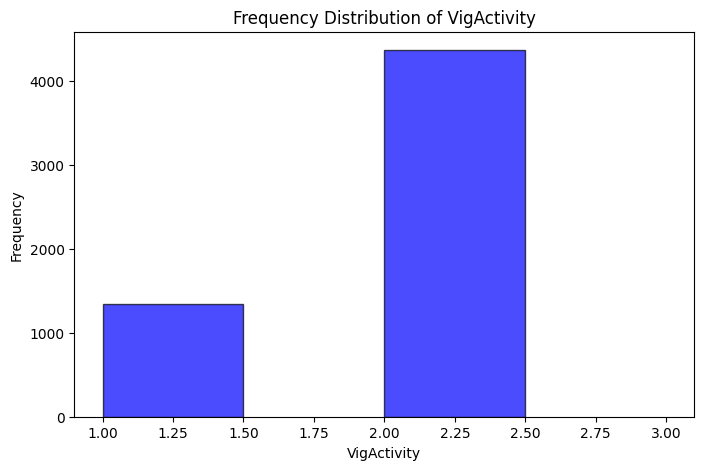

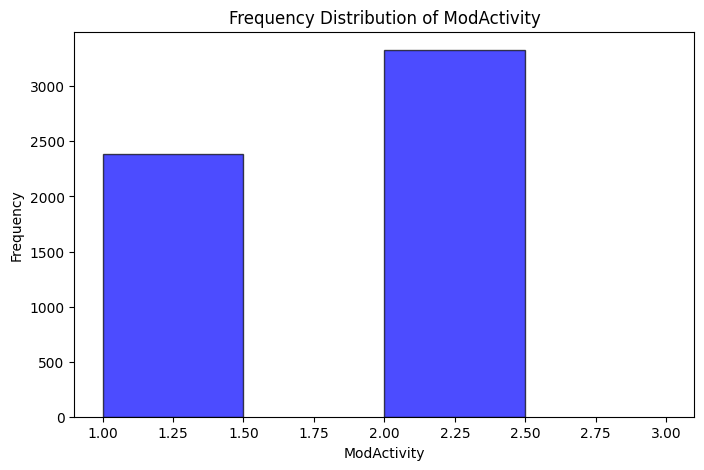

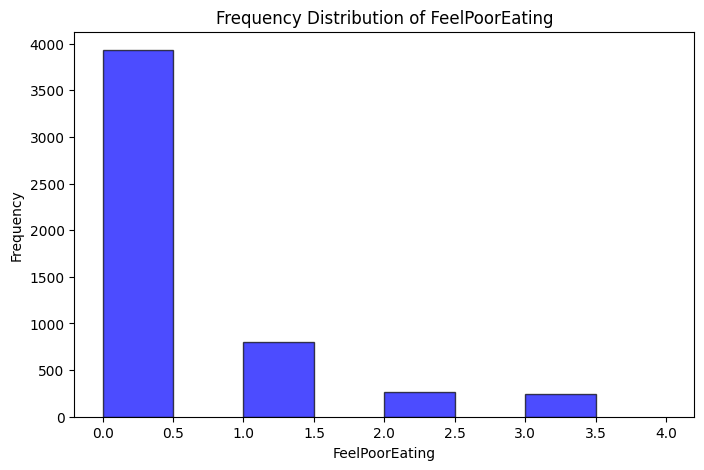

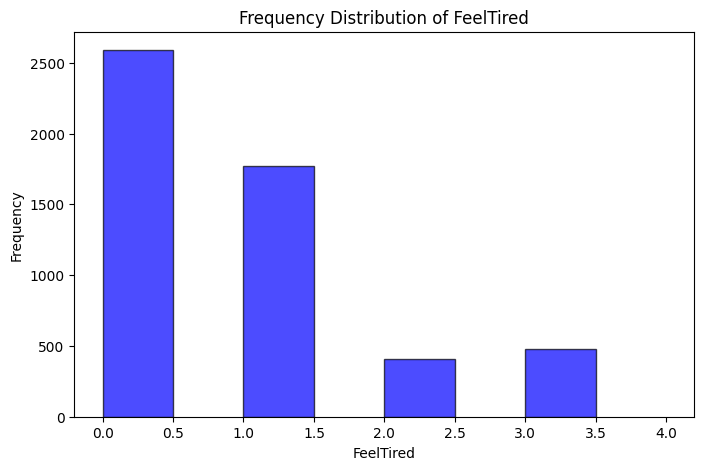

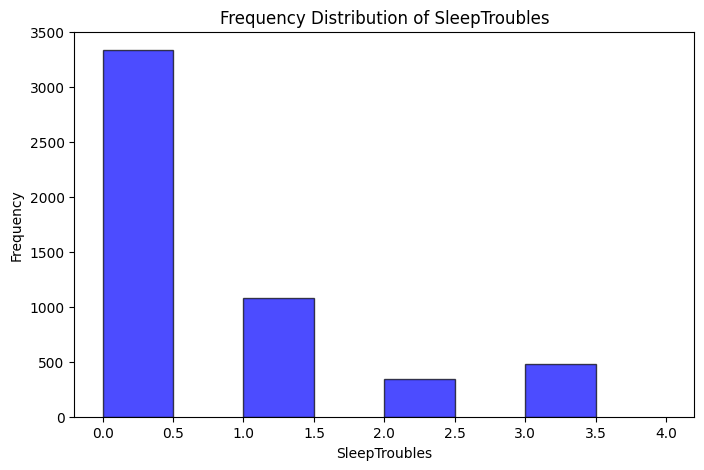

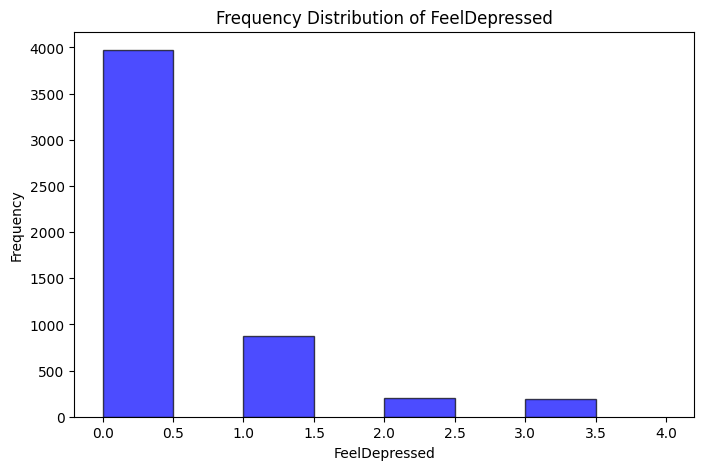

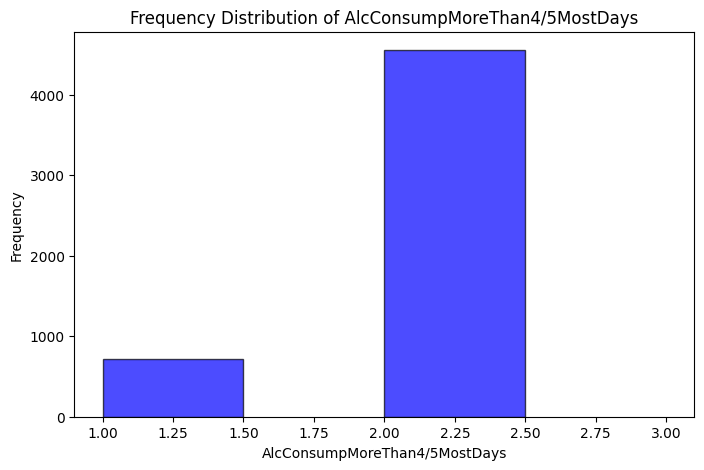

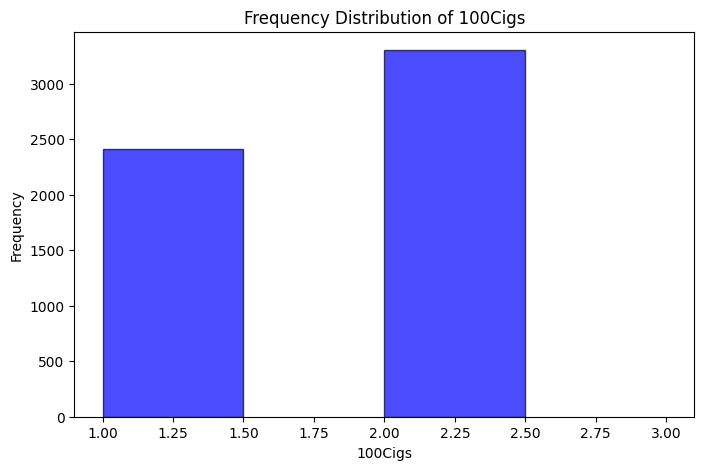

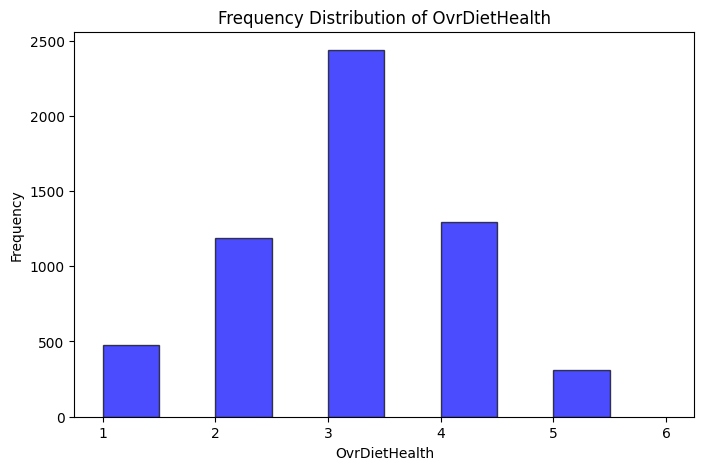

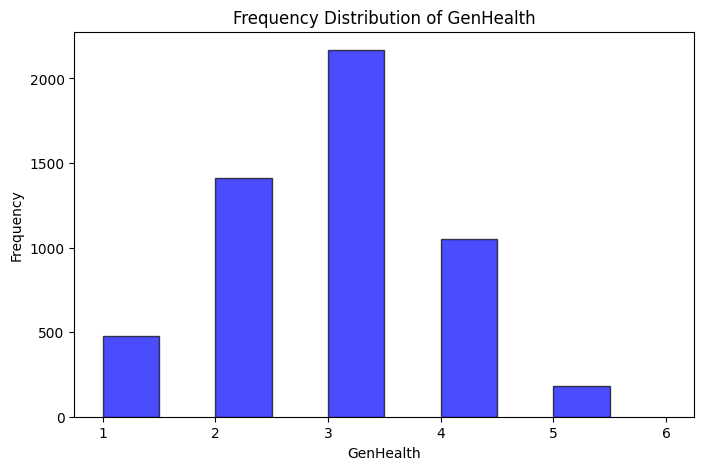

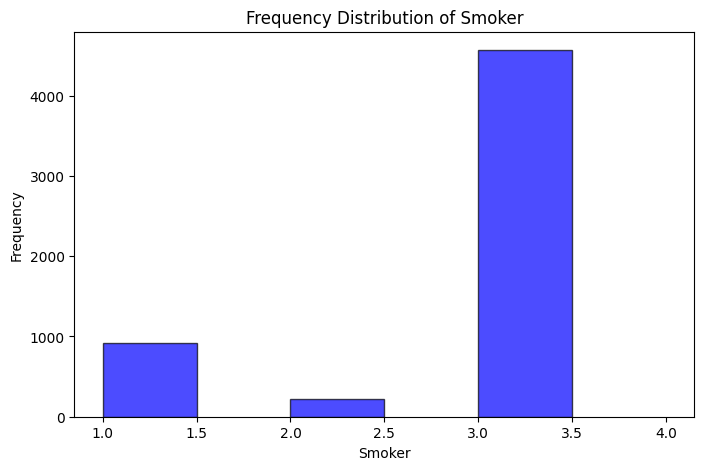

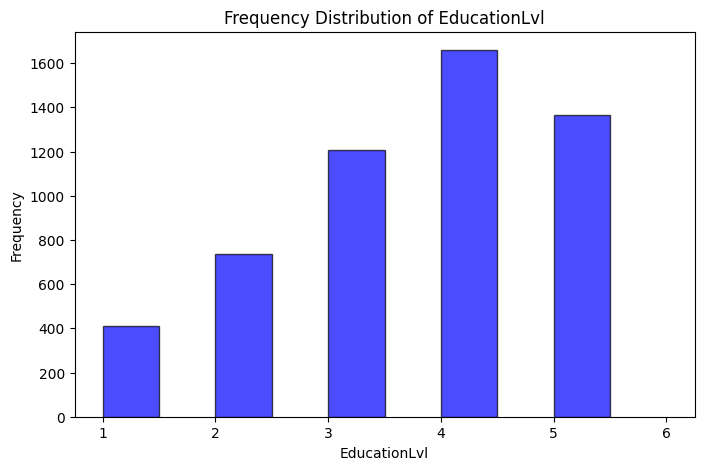

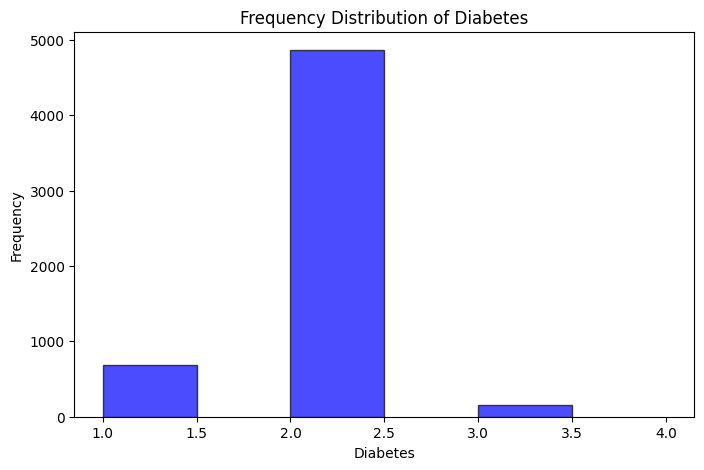

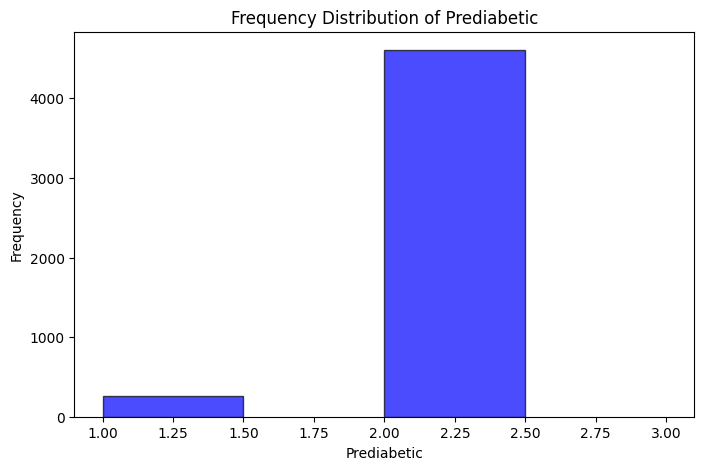

In [938]:
features_seven = ['Gender','Cholesterol','Diet','SaltFreq','Asthma', 'Stroke', 'VigActivity','ModActivity','FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed','AlcConsumpMoreThan4/5MostDays','100Cigs','OvrDietHealth','GenHealth','Smoker','EducationLvl','Diabetes','Prediabetic']
plot_feature_distribution(df, features_seven)

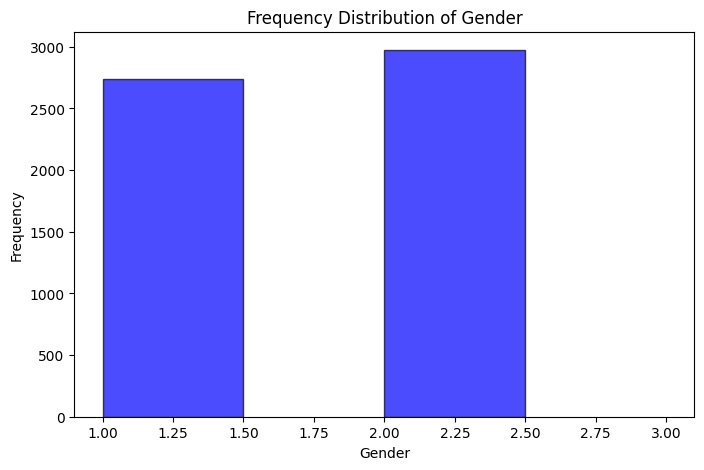

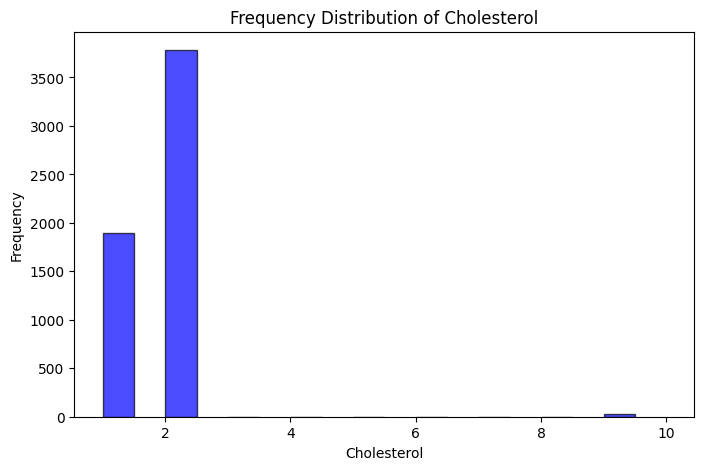

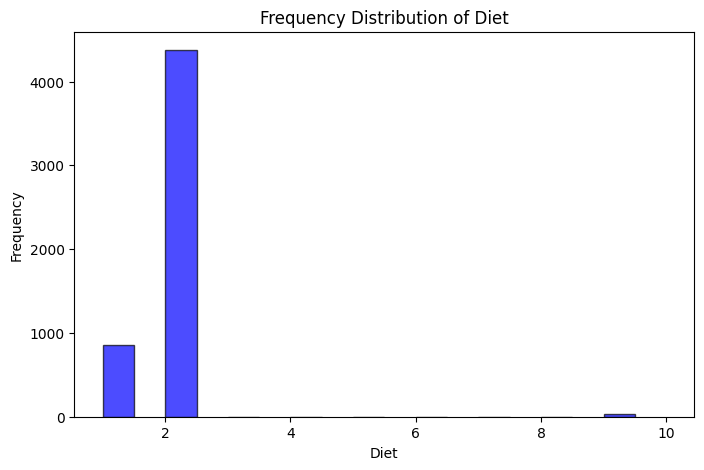

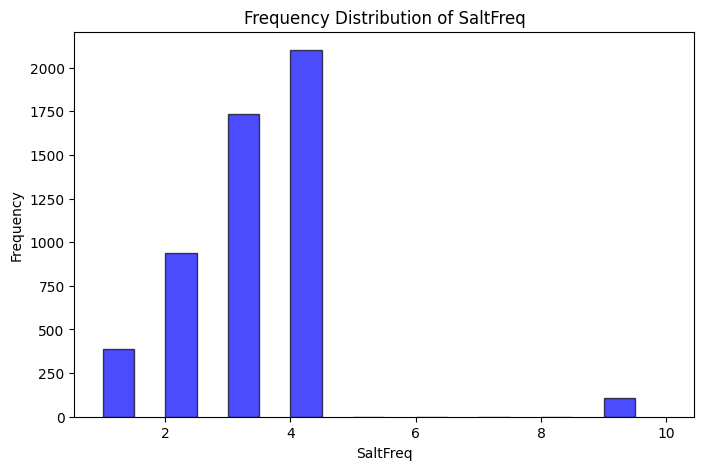

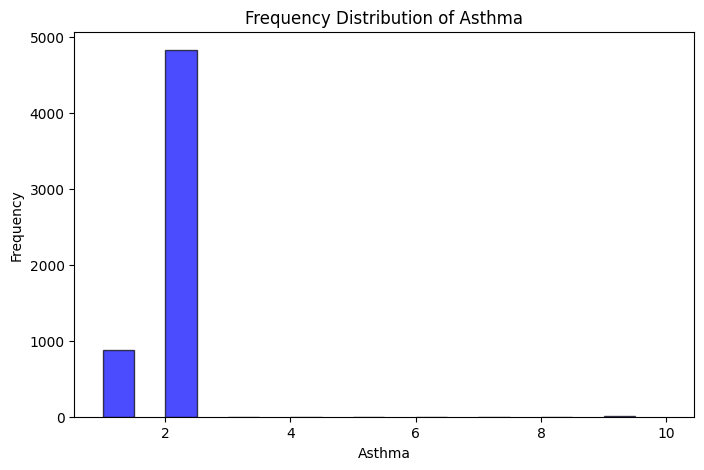

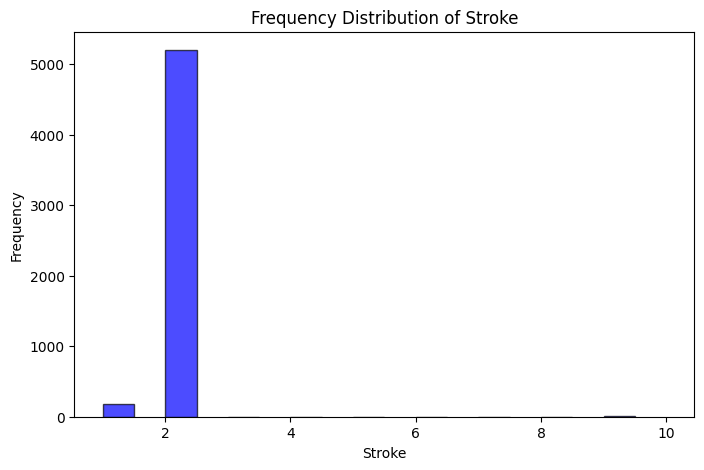

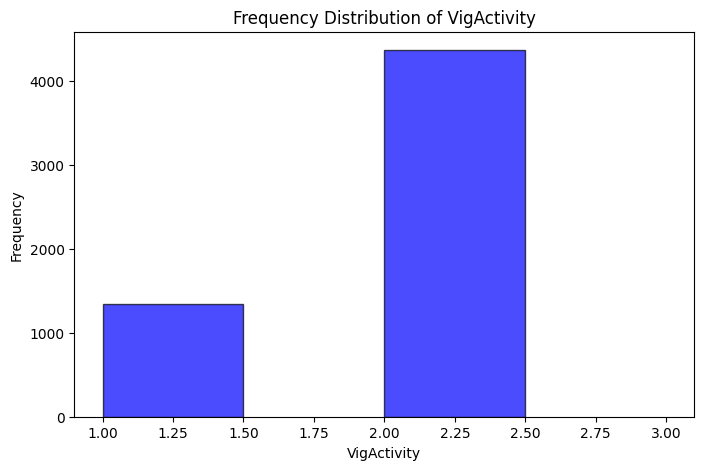

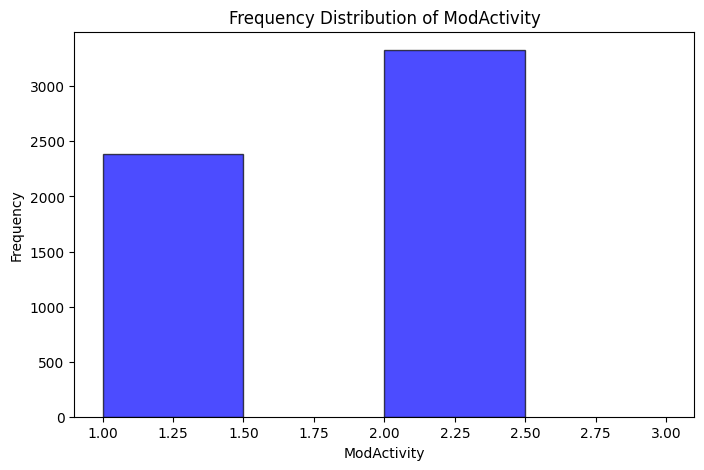

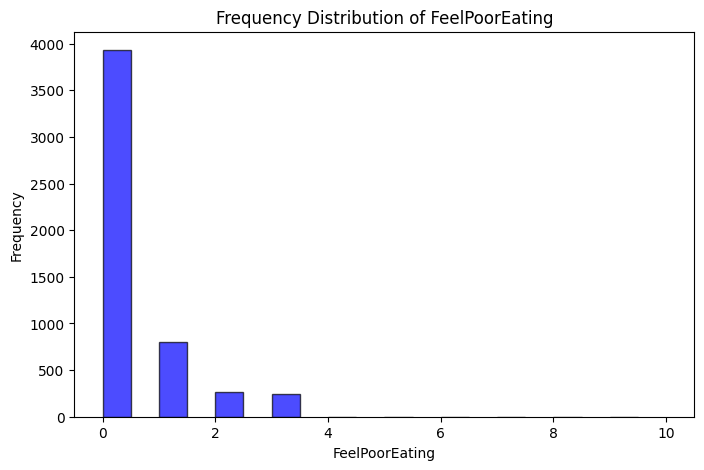

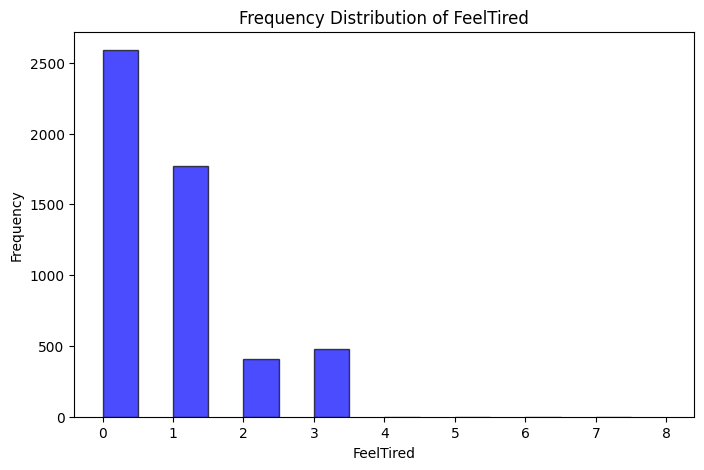

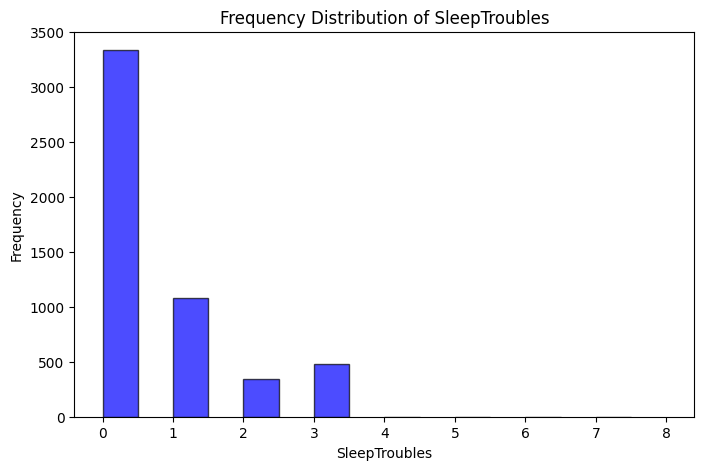

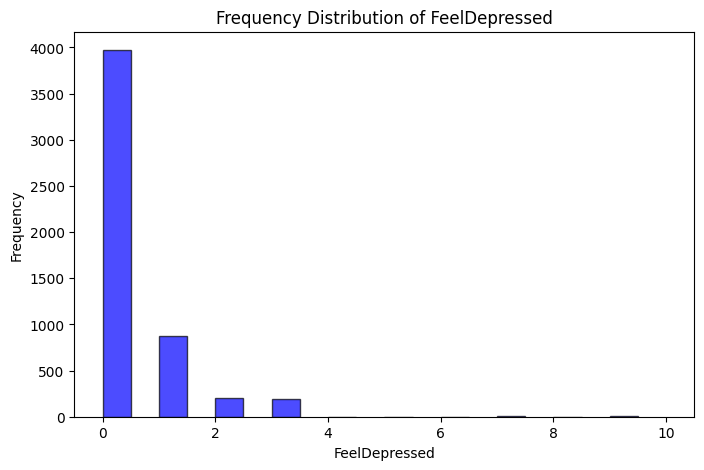

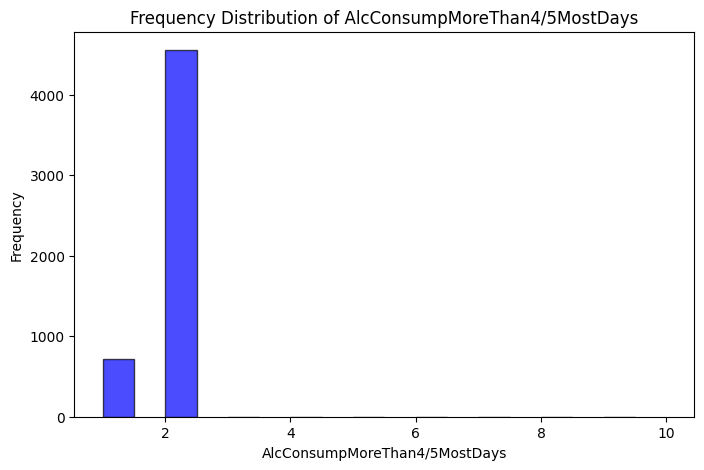

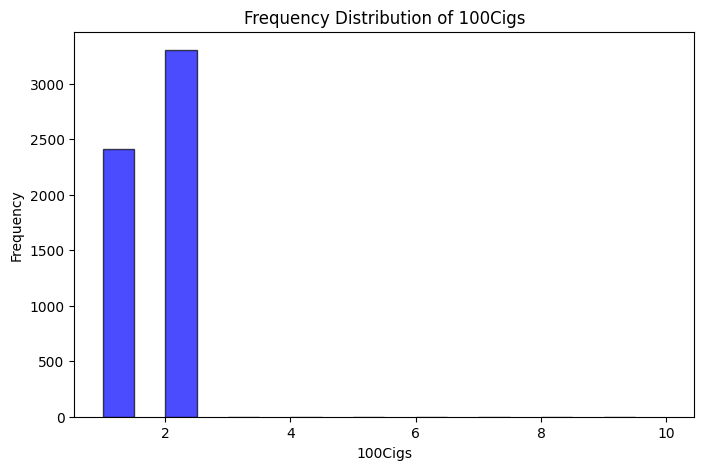

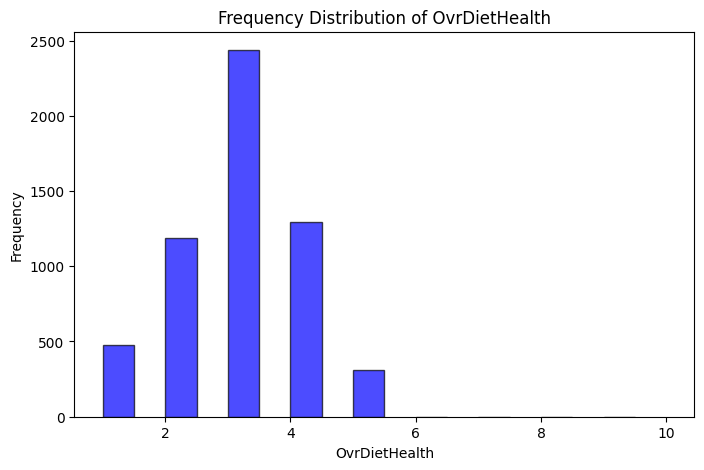

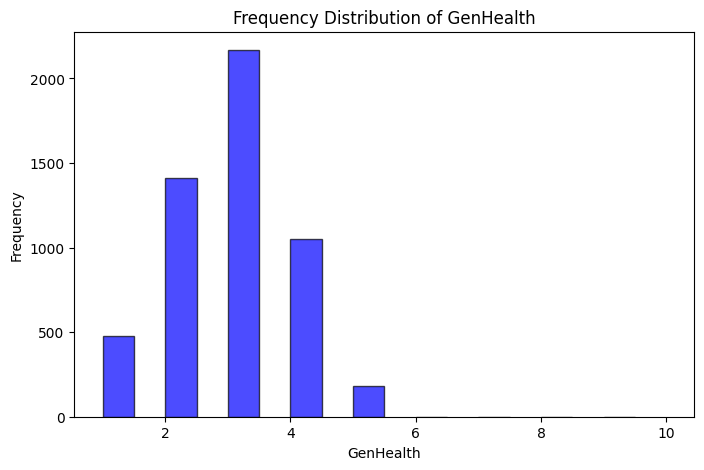

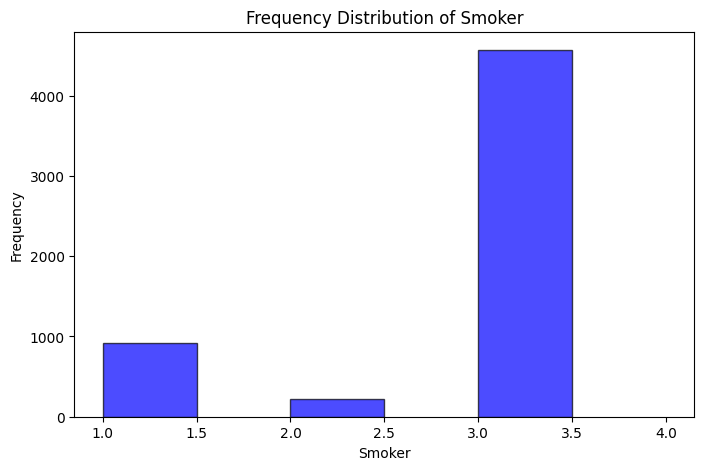

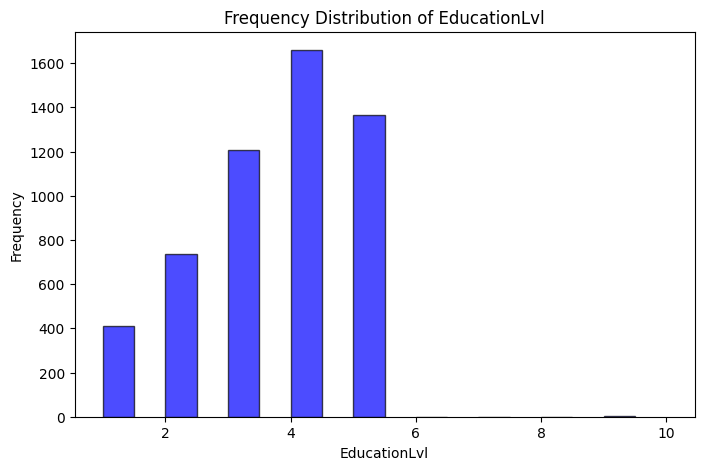

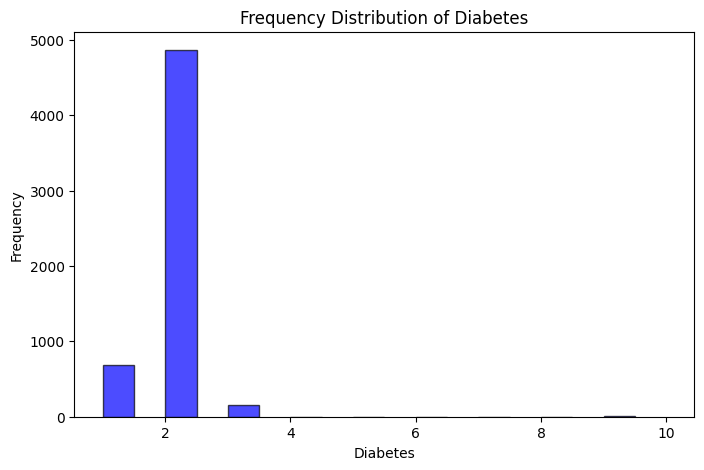

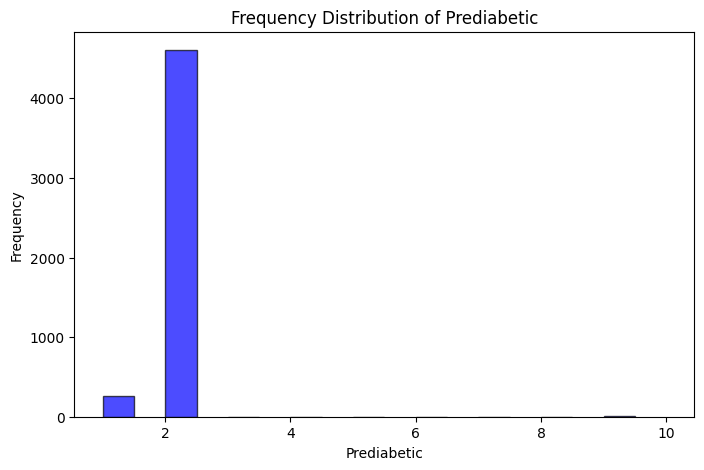

In [939]:
feature_seventy_seven = ['SleepDuringWork']
plot_feature_distribution(df, features_seven, 77)

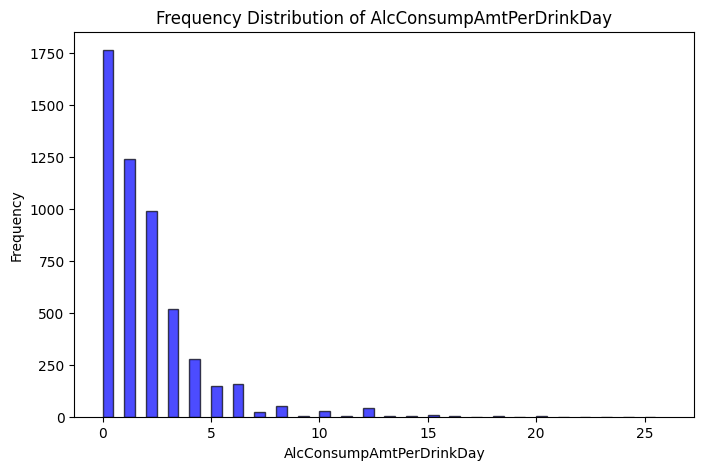

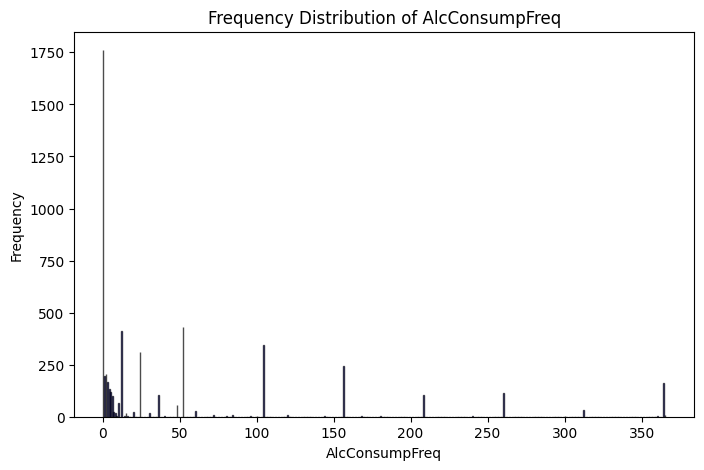

In [940]:
feature_seven_hundred = ['AlcConsumpAmtPerDrinkDay', 'AlcConsumpFreq']
plot_feature_distribution(df, feature_seven_hundred, 777)

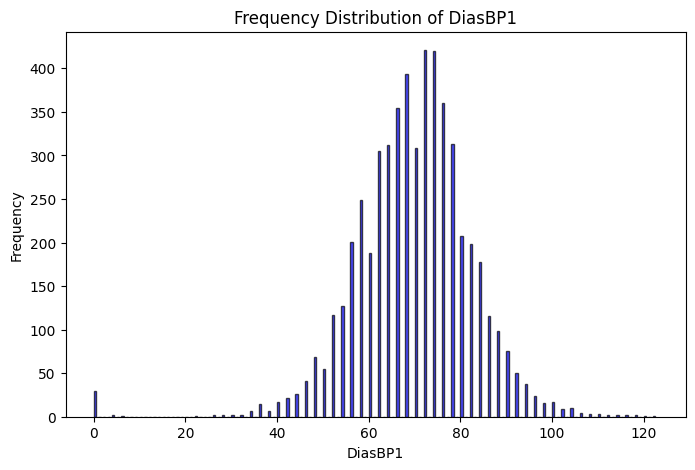

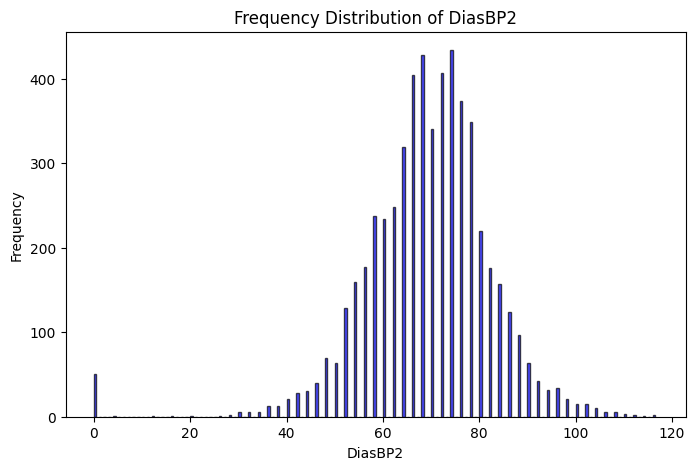

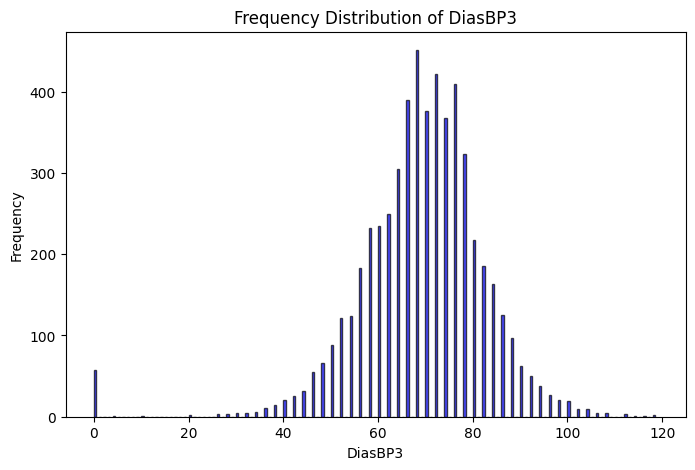

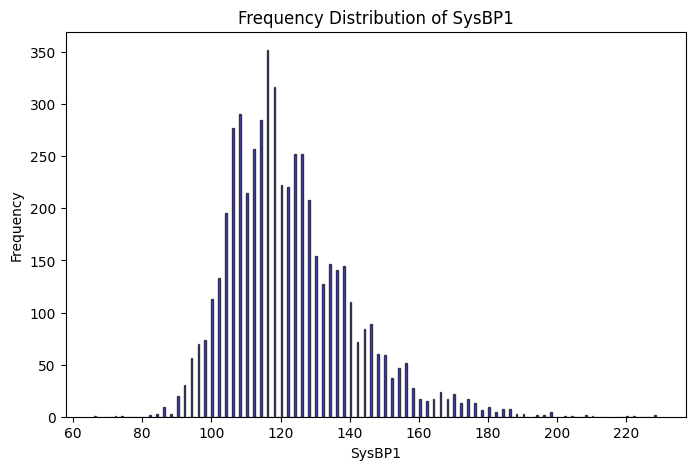

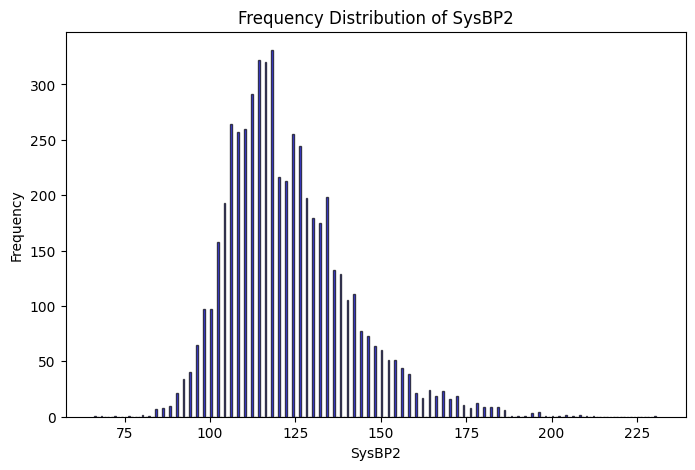

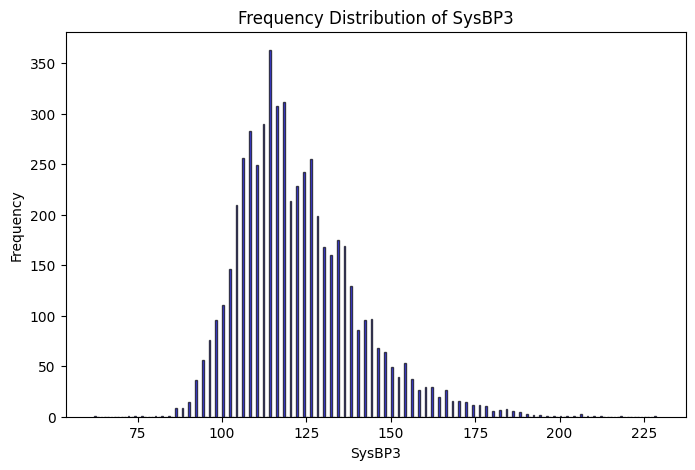

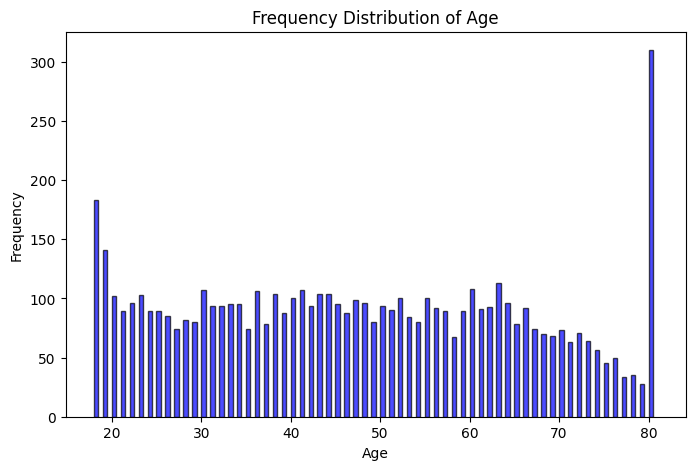

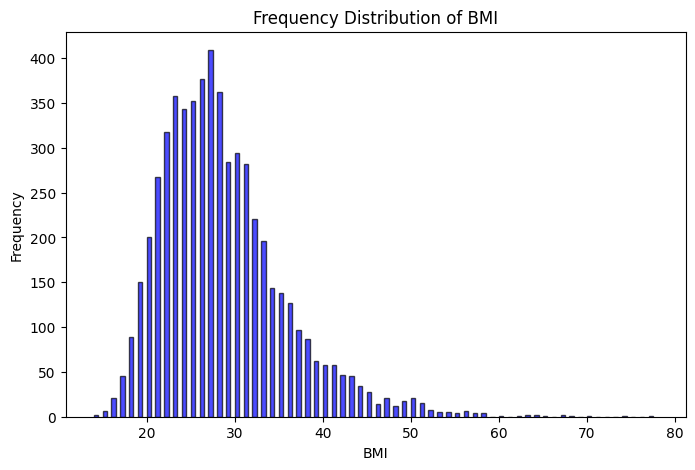

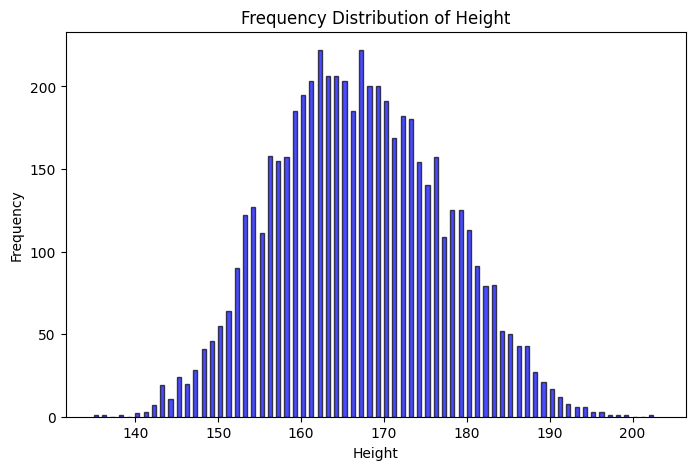

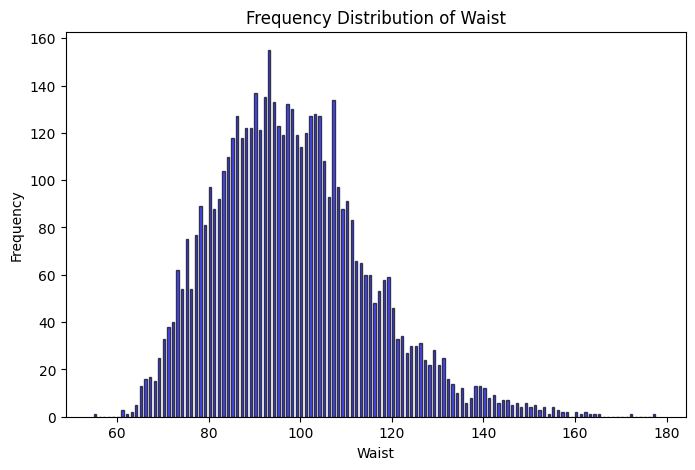

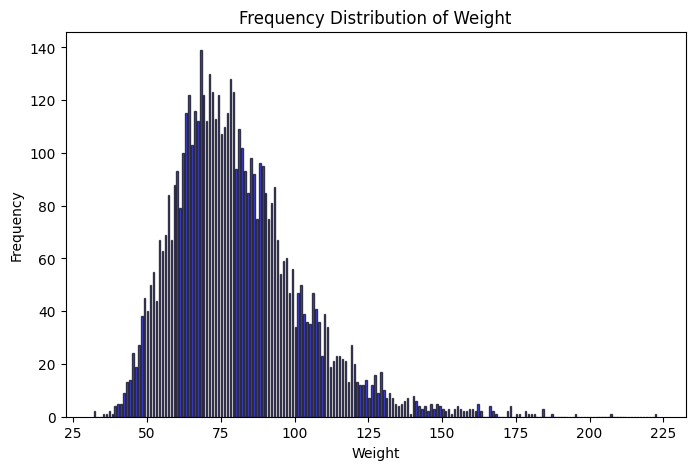

In [941]:
other_features = ['DiasBP1','DiasBP2','DiasBP3','SysBP1','SysBP2','SysBP3','Age', 'BMI','Height','Waist','Weight']
plot_feature_distribution(df, other_features, 1000000)

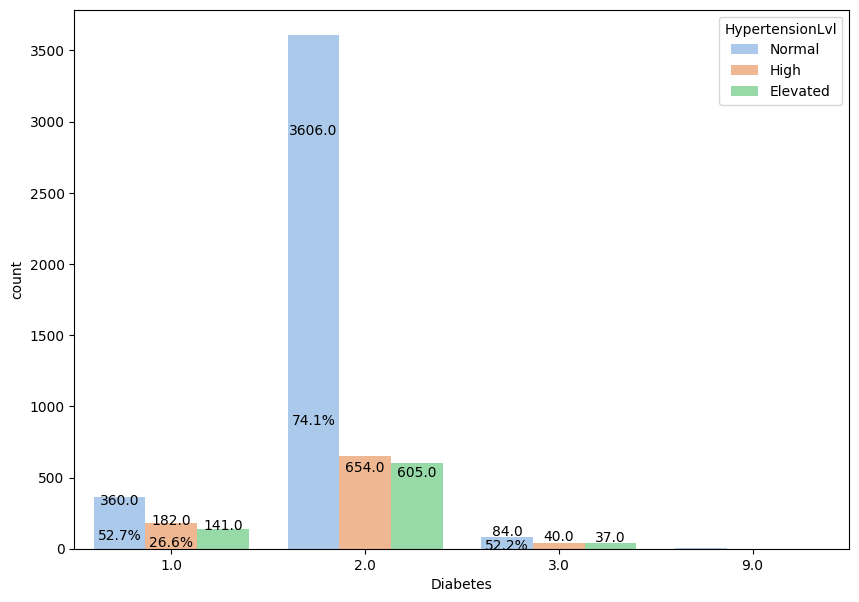

In [942]:
plot_bivariate('Diabetes', 'HypertensionLvl')

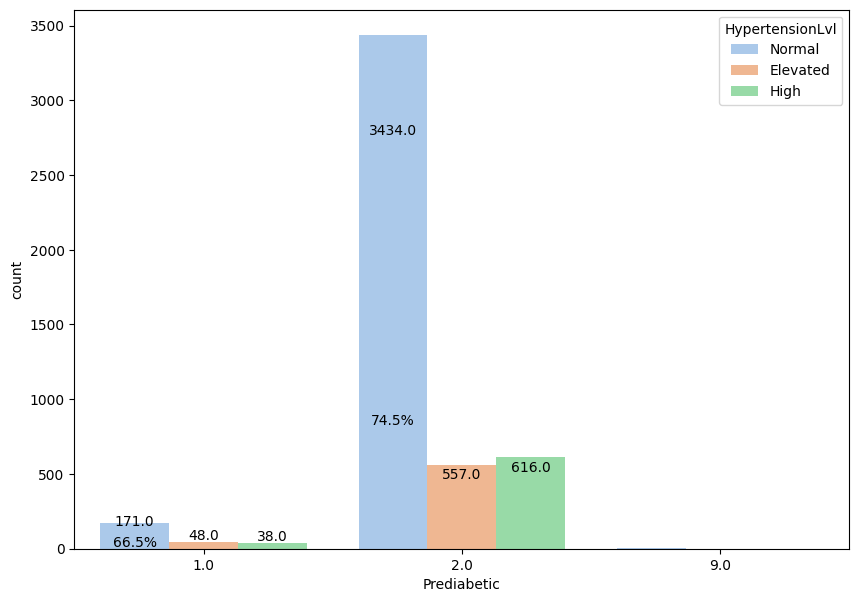

In [943]:
plot_bivariate('Prediabetic', 'HypertensionLvl')

# TODO
Prediabetes and Diabetes should be joined or considered together if prediabetes is used. 

### Model Building

In [944]:
# Print the count of null values for each column
# Drop columns with more than 2000 null values
df = df.dropna(thresh=len(df) - 2000, axis=1)

# Drop specific columns
df = df.drop(columns=['UnitAlc', 'ALQ101', 'Prediabetic', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1', 
                      'SysBP2', 'SysBP3', 'AvgDiasBP', 'AlcConsumpFreqBinned', 'AlcConsump/YrBinned', 
                      'yearsSmokedBinned', 'lifetimeCigarettesBinned'])
null_values = df.isnull().sum()

print("Null values in each column:")
print(null_values)

Null values in each column:
ID                                 0
Gender                             0
Age                                0
EducationLvl                     324
BMI                               61
Height                            52
Waist                            278
Weight                            49
Cholesterol                        0
Diet                             442
SaltFreq                         442
Asthma                             0
Stroke                           324
Diabetes                           0
VigActivity                        0
ModActivity                        0
FeelPoorEating                   463
FeelTired                        463
SleepTroubles                    463
FeelDepressed                    462
AlcConsumpMoreThan4/5MostDays    443
AlcConsumpFreq                   445
AlcConsumpAmtPerDrinkDay         444
100Cigs                            0
Smoker                             0
OvrDietHealth                      0
GenHealth 

In [945]:
# Print the number of rows without null values
num_rows_without_nulls = df.dropna().shape[0]
print(f"Number of rows without null values: {num_rows_without_nulls}")

Number of rows without null values: 4582


In [946]:
df = df.dropna()

null_values = df.isnull().sum()
print("Null values in each column:")
print(null_values)

Null values in each column:
ID                               0
Gender                           0
Age                              0
EducationLvl                     0
BMI                              0
Height                           0
Waist                            0
Weight                           0
Cholesterol                      0
Diet                             0
SaltFreq                         0
Asthma                           0
Stroke                           0
Diabetes                         0
VigActivity                      0
ModActivity                      0
FeelPoorEating                   0
FeelTired                        0
SleepTroubles                    0
FeelDepressed                    0
AlcConsumpMoreThan4/5MostDays    0
AlcConsumpFreq                   0
AlcConsumpAmtPerDrinkDay         0
100Cigs                          0
Smoker                           0
OvrDietHealth                    0
GenHealth                        0
SleepDuringWork            

# Classification Models

In [885]:
# Create the target variable
target = df['HypertensionLvl']

# Drop the HypertensionLvl column from the DataFrame
df = df.drop(columns=['HypertensionLvl', 'AvgSysBP'])

# Print the resulting DataFrame and the target variable to verify
print("DataFrame after dropping 'HypertensionLvl':")
print(df.head())
print("\nTarget variable 'HypertensionLvl':")
print(target.head())

DataFrame after dropping 'HypertensionLvl':
      ID  Gender  Age  EducationLvl   BMI  Height  Waist  Weight  Cholesterol  \
0  73557       1   69           3.0  26.7   171.3  100.0    78.3          1.0   
1  73558       1   54           3.0  28.6   176.8  107.6    89.5          1.0   
2  73559       1   72           4.0  28.9   175.3  109.2    88.9          1.0   
5  73562       1   56           4.0  41.7   158.7  123.1   105.0          1.0   
7  73564       2   61           5.0  35.7   161.8  110.8    93.4          2.0   

   Diet  ...  100Cigs  Smoker  OvrDietHealth  GenHealth  SleepDuringWork  \
0   2.0  ...      1.0     3.0            2.0        2.0              7.0   
1   2.0  ...      1.0     2.0            3.0        4.0              9.0   
2   1.0  ...      1.0     3.0            3.0        3.0              8.0   
5   2.0  ...      1.0     3.0            5.0        5.0              5.0   
7   2.0  ...      2.0     3.0            4.0        3.0              9.0   

   yearsSmok

In [886]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)
X_train, X_test, y_train, y_test = train_test_split(df, target_encoded, test_size=0.35, random_state=42)

# Print the shapes of the resulting splits to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Training set shape: (2978, 33)
Test set shape: (1604, 33)
Training target shape: (2978,)
Test target shape: (1604,)


## Logistic Regression

In [887]:
# Standardize the data (logistic regression performs better with scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model with a multi-class strategy
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Decode the predicted labels back to the original classes
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Decode the actual test labels back to the original classes
y_test_decoded = label_encoder.inverse_transform(y_test)

# Print classification results
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

print("\nAccuracy Score:")
print(accuracy_score(y_test_decoded, y_pred_decoded))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_decoded, y_pred_decoded))


Classification Report:
              precision    recall  f1-score   support

    Elevated       0.14      0.01      0.02       260
        High       0.33      0.20      0.25       230
      Normal       0.73      0.94      0.82      1114

    accuracy                           0.69      1604
   macro avg       0.40      0.38      0.36      1604
weighted avg       0.57      0.69      0.61      1604


Accuracy Score:
0.6851620947630923

Confusion Matrix:
[[   3   41  216]
 [   8   46  176]
 [  11   53 1050]]


In [947]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming df is already defined and loaded
# Create the target variable
target = df['HypertensionLvl']

# Drop the HypertensionLvl column from the DataFrame
df = df.drop(columns=['HypertensionLvl', 'AvgSysBP'])

# Print the resulting DataFrame and the target variable to verify
print("DataFrame after dropping 'HypertensionLvl':")
print(df.head())
print("\nTarget variable 'HypertensionLvl':")
print(target.head())

# Encode the target variable since logistic regression and random forest require numerical input
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Split the data into training and test sets using the encoded target variable
X_train, X_test, y_train, y_test = train_test_split(df, target_encoded, test_size=0.35, random_state=42)

# Print the shapes of the resulting splits to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

# Standardize the data (logistic regression performs better with scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model with a multi-class strategy
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# Fit the logistic regression model to the training data
logistic_model.fit(X_train_scaled, y_train)

# Predict on the test data using logistic regression
y_pred_logistic = logistic_model.predict(X_test_scaled)

# Decode the predicted labels back to the original classes for logistic regression
y_pred_logistic_decoded = label_encoder.inverse_transform(y_pred_logistic)

# Decode the actual test labels back to the original classes for logistic regression
y_test_decoded = label_encoder.inverse_transform(y_test)

# Print classification results for logistic regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_decoded, y_pred_logistic_decoded))

print("\nLogistic Regression Accuracy Score:")
print(accuracy_score(y_test_decoded, y_pred_logistic_decoded))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test_decoded, y_pred_logistic_decoded))

# Initialize the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the random forest model to the training data (no scaling needed for random forests)
rf_model.fit(X_train, y_train)

# Predict on the test data using random forest
y_pred_rf = rf_model.predict(X_test)

# Decode the predicted labels back to the original classes for random forest
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)

# Print classification results for random forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_decoded, y_pred_rf_decoded))

print("\nRandom Forest Accuracy Score:")
print(accuracy_score(y_test_decoded, y_pred_rf_decoded))

print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test_decoded, y_pred_rf_decoded))


DataFrame after dropping 'HypertensionLvl':
      ID  Gender  Age  EducationLvl   BMI  Height  Waist  Weight  Cholesterol  \
0  73557       1   69           3.0  26.7   171.3  100.0    78.3          1.0   
1  73558       1   54           3.0  28.6   176.8  107.6    89.5          1.0   
2  73559       1   72           4.0  28.9   175.3  109.2    88.9          1.0   
5  73562       1   56           4.0  41.7   158.7  123.1   105.0          1.0   
7  73564       2   61           5.0  35.7   161.8  110.8    93.4          2.0   

   Diet  ...  100Cigs  Smoker  OvrDietHealth  GenHealth  SleepDuringWork  \
0   2.0  ...      1.0     3.0            2.0        2.0              7.0   
1   2.0  ...      1.0     2.0            3.0        4.0              9.0   
2   1.0  ...      1.0     3.0            3.0        3.0              8.0   
5   2.0  ...      1.0     3.0            5.0        5.0              5.0   
7   2.0  ...      2.0     3.0            4.0        3.0              9.0   

   yearsSmok

## Encoding


In [115]:
def encode_yes_no_features(df, feature_names):
    for feature_name in feature_names:
        # Apply the conditions to each specified feature
        df[feature_name] = df[feature_name].apply(lambda x: 1 if x == 1 else (0 if x == 2 else np.nan))

In [116]:
yes_no_features = ['Gender', 'Asthma', 'Stroke', 'VigActivity', 'ModActivity', 'AlcConsumpMoreThan4/5MostDays', '100Cigs', 'Cholesterol', 'Diet', 'Prediabetic']
encode_yes_no_features(df, yes_no_features)

In [117]:
new_column_names = {
    'Gender': 'Male'
}

df.rename(columns=new_column_names, inplace=True)

In [118]:
def minus_one_from_feature_rating(df, feature_names):
    for feature_name in feature_names:
        df[feature_name] = df[feature_name] -1

In [119]:
features_to_minus_one = ['SaltFreq', 'OvrDietHealth', 'GenHealth', 'Smoker', 'EducationLvl', 'Diabetes']
minus_one_from_feature_rating(df, features_to_minus_one)

In [120]:
#Scale features
def scale_features(df, feature_names, threshold=6):
    for feature_name in feature_names:
        # Determine the max value in the feature that is less than the threshold
        max_scale = df[feature_name][df[feature_name] < threshold].max()
        
        # Apply the scaling operation x = x / max_scale if x is less than the threshold
        df[feature_name] = df[feature_name].apply(lambda x: x / max_scale if x < threshold else np.nan)

In [121]:
features_to_scale = ['FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed', 'SaltFreq','OvrDietHealth', 'GenHealth', 'Smoker', 'EducationLvl', 'Diabetes']
scale_features(df, features_to_scale)

In [122]:
features_to_scale = ['AlcConsumpFreq', 'AlcConsumpAmtPerDrinkDay']
scale_features(df, features_to_scale, threshold=777)

features_to_scale = ['SleepDuringWork']
scale_features(df, features_to_scale, threshold=77)

features_to_scale = ['AlcConsump/Yr', 'lifetimeCigarettes', 'yearsSmoked']
scale_features(df, features_to_scale, threshold=99999999999999999)

In [123]:
def flip_feature_scaling(df, feature_names):
    for feature_name in feature_names:
        df[feature_name] = 1 - df[feature_name]

In [124]:
features_to_flip = ['OvrDietHealth', 'GenHealth', 'Smoker']
flip_feature_scaling(df, features_to_flip)

In [125]:
df['Diabetes'] = df['Diabetes'].replace({3: 0.5, 2: 0})

In [126]:
def print_unique_values(df, features):

    for feature in features:
        if feature in df.columns:
            unique_values = df[feature].unique()
            print(f"Unique values for '{feature}': {unique_values}")
        else:
            print(f"Feature '{feature}' not found in the df.")

In [127]:
print_unique_values(df, ['OvrDietHealth', 'GenHealth', 'Smoker', 'FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed', 'SaltFreq','OvrDietHealth', 'GenHealth', 'Smoker', 'EducationLvl', 'Diabetes','Gender', 'Asthma', 'Stroke', 'VigActivity', 'ModActivity', 'AlcConsumpMoreThan4/5MostDays', '100Cigs', 'Cholesterol', 'Diet', 'Prediabetic'])

Unique values for 'OvrDietHealth': [0.75 0.5  0.   0.25 1.    nan]
Unique values for 'GenHealth': [0.75 0.25 0.5  0.   1.    nan]
Unique values for 'Smoker': [0.  0.5 1. ]
Unique values for 'FeelPoorEating': [0.         1.         0.33333333        nan 0.66666667]
Unique values for 'FeelTired': [0.         1.         0.33333333        nan 0.66666667]
Unique values for 'SleepTroubles': [0.         1.         0.33333333        nan 0.66666667]
Unique values for 'FeelDepressed': [0.         0.33333333 1.                nan 0.66666667]
Unique values for 'SaltFreq': [1.         0.66666667 0.33333333 0.                nan]
Unique values for 'OvrDietHealth': [0.75 0.5  0.   0.25 1.    nan]
Unique values for 'GenHealth': [0.75 0.25 0.5  0.   1.    nan]
Unique values for 'Smoker': [0.  0.5 1. ]
Unique values for 'EducationLvl': [0.5  0.75 1.   0.25 0.    nan]
Unique values for 'Diabetes': [0.  0.5 1.  nan]
Feature 'Gender' not found in the df.
Unique values for 'Asthma': [ 0.  1. nan]
Unique val